In [29]:
#Run Imports each time
import os, json, ast, csv, shutil, synapseclient
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
from scipy.signal import butter, lfilter, freqz
import math
import peakutils
from myconfig import *
%matplotlib inline

epoch = datetime.datetime.utcfromtimestamp(0)

#Constants
#PST is -7 so if we go from 8AM - 2PM we should go from 1AM
start_ms = unix_time_millis(datetime.datetime(2017, 9, 20, 8))
end_ms = unix_time_millis(datetime.datetime(2017, 9, 20, 23))
tableIds={"syn10170509":"6-Minute Walk Test Main",\
                      'syn4216032': "6-Minute Walk Test Disp"}
disp_table_fn = "6mwt-dist.csv"
table_fn = "6mwt-main.csv"
base_path="/Users/hershman/Amazon Drive/Stanford/Data/MHC-QA"


def toSeconds(x):
    return np.absolute(x.astype('int')/1e9)
def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def DownloadTableColumnsCreatedOn(syn, start, end, table_id = 'syn4927133', columns = [(-2, "other_feedback"), ], 
                  base_path = "/Users/hershman/Desktop", limit=50, table_fn = "table.csv"):
    """Does a lot
            Downloads data from column of index in table_id
            Puts it in base_path/column
            Summarizes output to screen or a file named out
            
        EDIT:S Downloads latest table and has limit
    """
    
    #make subdirs
    if not os.path.exists(base_path):
        os.mkdir(base_path)
    for _, column in columns: 
        if not os.path.exists("%s/%s/" % (base_path, column)):
            os.mkdir("%s/%s/" % (base_path, column))
    
    schema = syn.get(table_id)
    results = syn.tableQuery("SELECT * FROM %s WHERE \"createdOn\" > %d AND \"createdOn\" < %d" % (table_id, start, end), resultsAs="rowset")
    rows_list = []
    table_columns = [x['name'] for x in results.headers]
    
    for i, row in enumerate(results):
        #print row.rowId, row.versionNumber, row.values
        try:
            for index, column in columns:
                data_col = row['values'][index]
                if data_col:
                    if not os.path.exists("%s/%s/%s" % (base_path, column, data_col)):
                        old_fn = syn.downloadTableFile(schema,
                                              rowId=row.rowId,
                                              versionNumber=row.versionNumber, 
                                              column=column,
                                              downloadLocation='.',
                                              ifcollision="keep.local")

                        new_fn = "%s/%s/%s" % (base_path, column, data_col)
                        #print old_fn['path']
                        os.rename(old_fn['path'],  new_fn)
                        #print old_fn, new_fn
                else:
                    pass
                    #print "No data", row.rowId, row.versionNumber, row.values
                    


        except:
            print "there was an exception..."
        dict1 = dict(zip(table_columns, row.items()[1][1]))
        rows_list.append(dict1)  
            
        if i == limit:
            print "Ending at limit %d" % limit
            break
            
            
    df = pd.DataFrame(rows_list)
    df.to_csv(os.path.join(base_path, table_fn), index = False, columns = table_columns)
    return df

def getSynapseTableCreatedOn(syn,
                     start,
                     end,
                    data_dir='.', 
                    tableIds={"syn10170509":"6-Minute Walk Test Main",\
                      'syn4216032': "6-Minute Walk Test Disp"}):
    """
    Logs you into Synapse and gets data from tables CreatedOn
    """
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for table in tableIds:
        name = tableIds[table]
        response = syn.tableQuery("SELECT * FROM %s WHERE \"createdOn\" > %d AND \"createdOn\" < %d" % (table, start, end) )
        shutil.move(response.filepath, join(data_dir, '%s.csv' % name))
        print "Downloaded %s (%s)" % (name, table)

def ReadAndAugmentDisp(in_fn, filt):
    df = pd.read_json(in_fn)
    df["dx"] = df.displacement * np.cos(df.direction)
    df["dy"] = df.displacement * np.sin(df.direction)
    # sum displacements to coordinates
    df["x"] = df.dx.cumsum()
    df["y"] = df.dy.cumsum()
    
    df = df[df.horizontalAccuracy < filt] #moved here from after x,y calc
    
    if df.shape[0]==0:
        return df
    #these three lines are new in 2:
    offset_x = df.x.min()
    offset_y = df.y.min()
    df["disp_from_min"] = ((df.x-offset_x)**2 + (df.y-offset_y)**2).apply(np.sqrt)
    
    
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S-0700')
    df["timestamp_time"] = df["timestamp"].apply(dateparse)
    df["timestamp_offset"] = df["timestamp_time"] - min(df["timestamp_time"])
    
    return df

def ComputeDistanceFromDisplacements(disp_fn):
    df = pd.read_json(disp_fn)
    # convert to x,y dipslacments
    df["dx"] = df.displacement * np.cos(df.direction)
    df["dy"] = df.displacement * np.sin(df.direction)
    # sum displacements to coordinates
    df["x"] = df.dx.cumsum()
    df["y"] = df.dy.cumsum()
    
    dist = 0
    x = 0
    y = 0
    
    df_f=df[df.horizontalAccuracy < 66]
    
    for row in df.iterrows():
        row_data = row[1]
        #print x, y, row_data[x], row_data
        dist += math.sqrt((x-row_data["x"])**2 + (y-row_data["y"])**2)
        x = row_data["x"]
        y = row_data["y"]
    return dist

def DistPlot(in_fn):
    df = pd.read_json(in_fn)
    df["dx"] = df.displacement * np.cos(df.direction)
    df["dy"] = df.displacement * np.sin(df.direction)
    # sum displacements to coordinates
    df["x"] = df.dx.cumsum()
    df["y"] = df.dy.cumsum()

    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S-0700')
    df["timestamp_time"] = df["timestamp"].apply(dateparse)
    df["timestamp_offset"] = df["timestamp_time"] - min(df["timestamp_time"])
    
    df_filt = df[df.horizontalAccuracy < 56]

    # example data
    x = df_filt["x"]
    y = df_filt["y"]

    # example variable error bar values
    yerr = df_filt["horizontalAccuracy"] # in meters: https://developer.apple.com/documentation/corelocation/cllocation/1423599-horizontalaccuracy
    xerr = df_filt["horizontalAccuracy"]

    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure(figsize=(16,16))
    #plt.errorbar(x, y, xerr=xerr, yerr=yerr)

    cmap=plt.get_cmap("hsv")
    seconds = df_filt["timestamp_offset"].values / 1e9 * 256/420
    colors = cmap(seconds.tolist())
    plt.scatter(x, y, color=colors, s=50, zorder=3)

    plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")
    return plt


def DistPlots(in_fn, in_fn2, filt=56):
    """Plots paths from iPhone and iPod"""
    df_filt = ReadAndAugmentDisp(in_fn, filt)
    df_filt2 = ReadAndAugmentDisp(in_fn2, filt)

    #  data
    x = df_filt["x"]
    y = df_filt["y"]
    x2 = df_filt2["x"]
    y2 = df_filt2["y"]
    
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure(figsize=(16,16))
    #plt.errorbar(x, y, xerr=xerr, yerr=yerr)

    cmap=plt.get_cmap("hsv")
    
    seconds = df_filt["timestamp_offset"].values / 1e9 * 256/420
    colors = cmap(seconds.tolist())
    plt.scatter(x, y, color=colors, s=50, zorder=3)
    plt.plot(x, y, c="b")
    
    seconds2 = df_filt2["timestamp_offset"].values / 1e9 * 256/420
    colors2 = cmap(seconds2.tolist())
    plt.scatter(x2, y2, color=colors2, s=50, zorder=3)
    plt.plot(x2, y2, c="k")

    plt.title("iPhone 6 (Blue) & iPhone SE (Black) 6MWT")
    return plt


def DispFromZeroPlot(in_fn, filt=600, title=""):
    """Plots distance from (min(x), min(x), vs time) from two input files"""
    df = ReadAndAugmentDisp(in_fn, filt)
    if df.shape[0] < 300:
        print "Short df, no plot"
        return 
    offset_x = df.x.min()
    offset_y = df.y.min()
    df["dispFromZero"] = ((df.x-offset_x)**2 + (df.y-offset_y)**2).apply(np.sqrt)
    plt.figure()
    plt.title(title)
    df["dispFromZero"].plot()
    return df

def DispFromZeroPlots(in_fn,in_fn2, filt=600, adjust=True):
    """Overlays plots distance from (min(x), min(x), vs time) from two input files"""
    df = ReadAndAugmentDisp(in_fn, filt)
    df2 = ReadAndAugmentDisp(in_fn2, filt)
    if df.shape[0] < 300 or df2.shape[0] < 300:
        print "Short df, no plot"
        return     

    x = df.timestamp_offset
    y = df["disp_from_min"]
    x2 = df2.timestamp_offset
    y2 = df2["disp_from_min"]
    
    if adjust:
        y2 += y.max()-y2.max() #adjust to match max
    
    plt.figure(figsize=(16,16))
    plt.plot(x, y, c="b")
    plt.plot(x2, y2, c="k")

    return plt

def PeakPlot(in_fn, filt=600, title=""):
    """ Like DispFromZeroPlot but also plots max/min"""
    df = ReadAndAugmentDisp(in_fn, filt)
    if df.shape[0] < 300:
        print "Short df, no plot"
        return None
    offset_x = df.x.min()
    offset_y = df.y.min()
    df.disp_from_min = ((df.x-offset_x)**2 + (df.y-offset_y)**2).apply(np.sqrt)


    #Peak detection
    peaks = peakutils.indexes(df.disp_from_min, thres=0.0, min_dist=2)
    valleys = peakutils.indexes(-df.disp_from_min, thres=0.0, min_dist=2)
    indices = peaks.tolist()  + valleys.tolist()
    indices.sort()

    # peakutils.interpolate(df.timestamp_offset.map(toSeconds).values, df.disp_from_min.values, ind=indices)
    
    x = df.timestamp_offset.map(toSeconds).values
    y = df.disp_from_min.values

    #plot
    fig, ax = plt.subplots(figsize=(20,4))
    ax.set_xlim(x.min(),x.max())
    ax.plot(x,y, color="k")
    ax.scatter(x[peaks],y[peaks], color="red")
    ax.scatter(x[valleys],y[valleys], color="blue")
    ax.text(4, 175, "Peaks: "+str(y[peaks]), color="red")
    ax.text(4, 160, "Valleys: "+str(y[valleys]), color="blue")
    plt.title(title)
    print y[peaks], y[valleys]
    return x, y, y[peaks], y[valleys]


syn = synapseclient.Synapse()
syn.login(USER, PASSWORD)

Welcome,  !




UPGRADE AVAILABLE

A more recent version of the Synapse Client (1.7.2) is available. Your version (1.6.2) can be upgraded by typing:
    pip install --upgrade synapseclient

Python Synapse Client version 1.7.2 release notes

https://github.com/Sage-Bionetworks/synapsePythonClient/blob/master/release_notes/release-1.7.1.md



# Code to download tables and/or files

In [2]:
# OPTIONAL Download tables but not data
getSynapseTableCreatedOn(syn, start_ms, end_ms, data_dir='../Data/MHC-QA')

Downloaded 6-Minute Walk Test Disp (syn4216032)
Downloaded 6-Minute Walk Test Main (syn10170509)


In [22]:
# download 6mwt displacements and table
columns = ( (-1, "UnknownFile_1.json.items"),)

disp_df = DownloadTableColumnsCreatedOn(syn, start_ms, end_ms, table_id = 'syn4216032', columns = columns, 
              base_path=base_path, table_fn = disp_table_fn)

In [23]:
# download 6mwt HealthKit and acceleromter data & table
columns = ( (10, "pedometer_fitness.walk.items"), 
            (11, 'accel_fitness_walk.json.items'),
            (12, 'deviceMotion_fitness.walk.items'),
            (13, 'HKQuantityTypeIdentifierHeartRate_fitness.walk.items'),
            (14, 'accel_fitness_rest.json.items'),
            (15, 'deviceMotion_fitness.rest.items'),
            (16, 'HKQuantityTypeIdentifierHeartRate_fitness.rest.items'))

df = DownloadTableColumnsCreatedOn(syn, start_ms, end_ms, table_id = 'syn10170509', columns = columns, 
              base_path=base_path, table_fn = table_fn)

# Read main data tables

In [20]:
#!!! Doesn't work - need to parse createdOn better. Just use download code above each time
disp_df = pd.read_csv(join(base_path, disp_table_fn))
df = pd.read_csv(join(base_path, table_fn))

# Analysis

In [24]:
for row in disp_df.iterrows():
    dist = ComputeDistanceFromDisplacements(join(base_path, "UnknownFile_1.json.items", str(row[1]["UnknownFile_1.json.items"])))
    if "6" in row[1]["phoneInfo"]:
        print row[1]["phoneInfo"], row[1]["createdOn"]- datetime.timedelta(hours=7),"\t", dist

iPhone 6 2017-09-20 09:40:23 	1526.26339519
iPhone 6 2017-09-20 10:06:07 	1327.77080315
iPhone 6 2017-09-20 10:19:40 	1324.63254042
iPhone 6 2017-09-20 10:57:34 	1264.66504084
iPhone 6 2017-09-20 11:22:56 	1103.62791568
iPhone 6 2017-09-20 11:33:27 	1256.74647526
iPhone 6 2017-09-20 11:45:45 	1159.21006649
iPhone 6 2017-09-20 11:56:56 	1054.81637242
iPhone 6 2017-09-20 12:24:48 	876.914521627
iPhone 6 2017-09-20 12:40:40 	776.710241561
iPhone 6 2017-09-20 13:07:20 	1144.21945529
iPhone 6 2017-09-20 13:19:52 	1628.80282924
iPhone 6 2017-09-20 13:31:55 	744.342107481


In [19]:
for row in disp_df.iterrows():
    dist = ComputeDistanceFromDisplacements(join(base_path, "UnknownFile_1.json.items", str(row[1]["UnknownFile_1.json.items"])))
    print dist, 

786.630206752
422.403107787
769.766979626
1526.26339519
187.874386132
1327.77080315
648.391314558
1324.63254042
1141.54608275
429.715948066
1402.3880703
1264.66504084
1191.41309222
1165.12396833
1103.62791568
1256.74647526
537.807198604
1159.21006649
635.68609992
1054.81637242
876.914521627
907.905406483
776.710241561
1144.21945529
878.474759982
1223.36499383
1628.80282924
744.342107481


In [58]:
for row in disp_df.iterrows():
    print row[1]["createdOn"]- datetime.timedelta(hours=7)

2017-09-20 04:58:24
2017-09-20 09:22:56
2017-09-20 09:40:22
2017-09-20 09:40:23
2017-09-20 09:51:55
2017-09-20 10:06:07
2017-09-20 10:06:58
2017-09-20 10:19:40
2017-09-20 10:20:10
2017-09-20 10:43:43
2017-09-20 10:57:15
2017-09-20 10:57:34
2017-09-20 11:09:45
2017-09-20 11:22:01
2017-09-20 11:22:56
2017-09-20 11:33:27
2017-09-20 11:33:40
2017-09-20 11:45:45
2017-09-20 11:56:35
2017-09-20 11:56:56
2017-09-20 12:24:48
2017-09-20 12:26:02
2017-09-20 12:40:40
2017-09-20 13:07:20
2017-09-20 13:08:11
2017-09-20 13:19:29
2017-09-20 13:19:52
2017-09-20 13:31:55


# Plot example data file with error bars

In [148]:
in_fn = join(base_path, "UnknownFile_1.json.items", disp_df.tail(1)["UnknownFile_1.json.items"].get_values()[0])

df = pd.read_json(in_fn)
df["dx"] = df.displacement * np.cos(df.direction)
df["dy"] = df.displacement * np.sin(df.direction)
# sum displacements to coordinates
df["x"] = df.dx.cumsum()
df["y"] = df.dy.cumsum()

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S-0700')
df["timestamp_time"] = df["timestamp"].apply(dateparse)
df["timestamp_offset"] = df["timestamp_time"] - min(df["timestamp_time"])

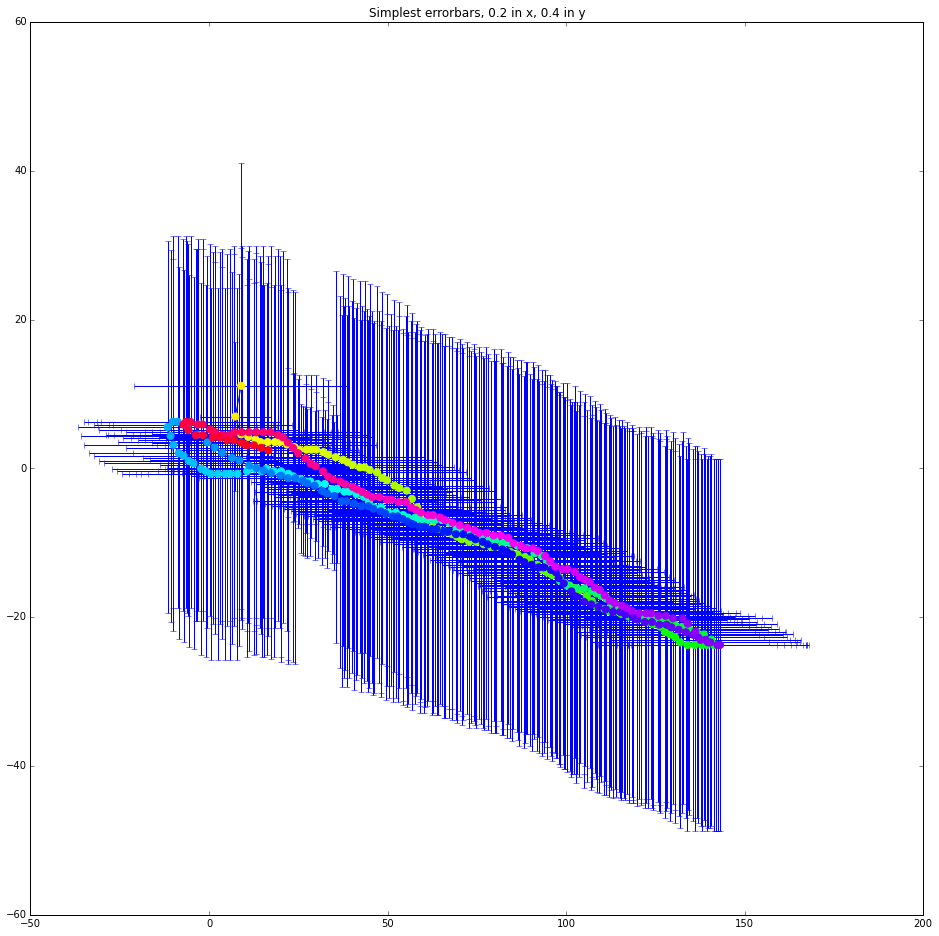

In [150]:
df_filt = df[df.horizontalAccuracy < 56]

# example data
x = df_filt["x"]
y = df_filt["y"]

# example variable error bar values
yerr = df_filt["horizontalAccuracy"] # in meters: https://developer.apple.com/documentation/corelocation/cllocation/1423599-horizontalaccuracy
xerr = df_filt["horizontalAccuracy"]

# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(16,16))
plt.errorbar(x, y, xerr=xerr, yerr=yerr)

cmap=plt.get_cmap("hsv")
seconds = df_filt["timestamp_offset"].values / 1e9 * 256/420
colors = cmap(seconds.tolist())
plt.scatter(x, y, color=colors, s=50, zorder=3)

plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")

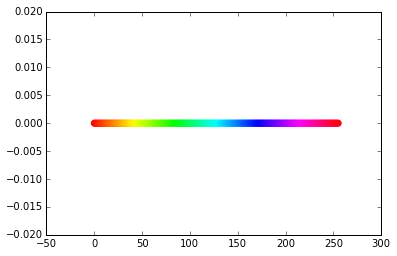

In [32]:
#Color map from 0 to 420 seconds.
cmap=plt.get_cmap("hsv")
colors = cmap(range(420*256/420))
plt.scatter(range(420*256/420), [0]*len(range((420*256/420))), c=colors,  lw = 0,  s=50)

iPhone8,4
iPhone8,4
iPhone8,4
iPhone 6
iPhone8,4
iPhone 6
iPhone8,4
iPhone 6
iPhone8,4
iPhone8,4
iPhone8,4
iPhone 6
iPhone8,4
iPhone8,4
iPhone 6
iPhone 6
iPhone8,4
iPhone 6
iPhone8,4
iPhone 6
iPhone 6
iPhone8,4
iPhone 6
iPhone 6
iPhone8,4
iPhone8,4
iPhone 6
iPhone 6


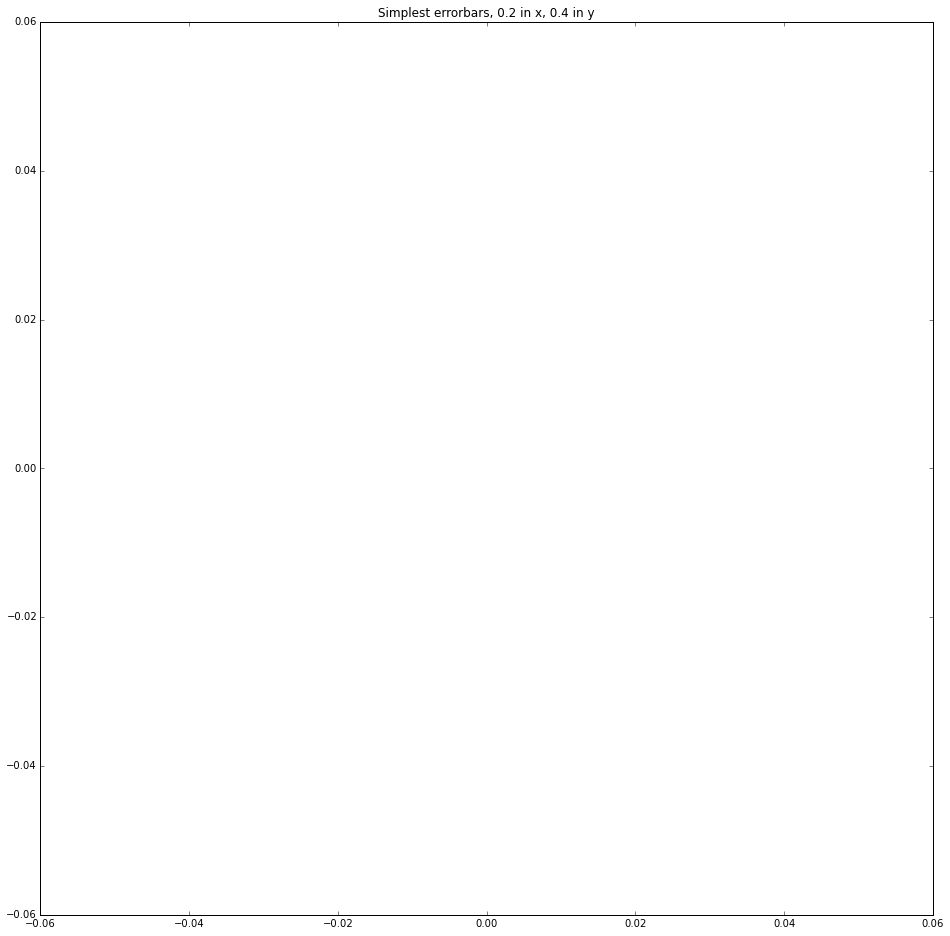

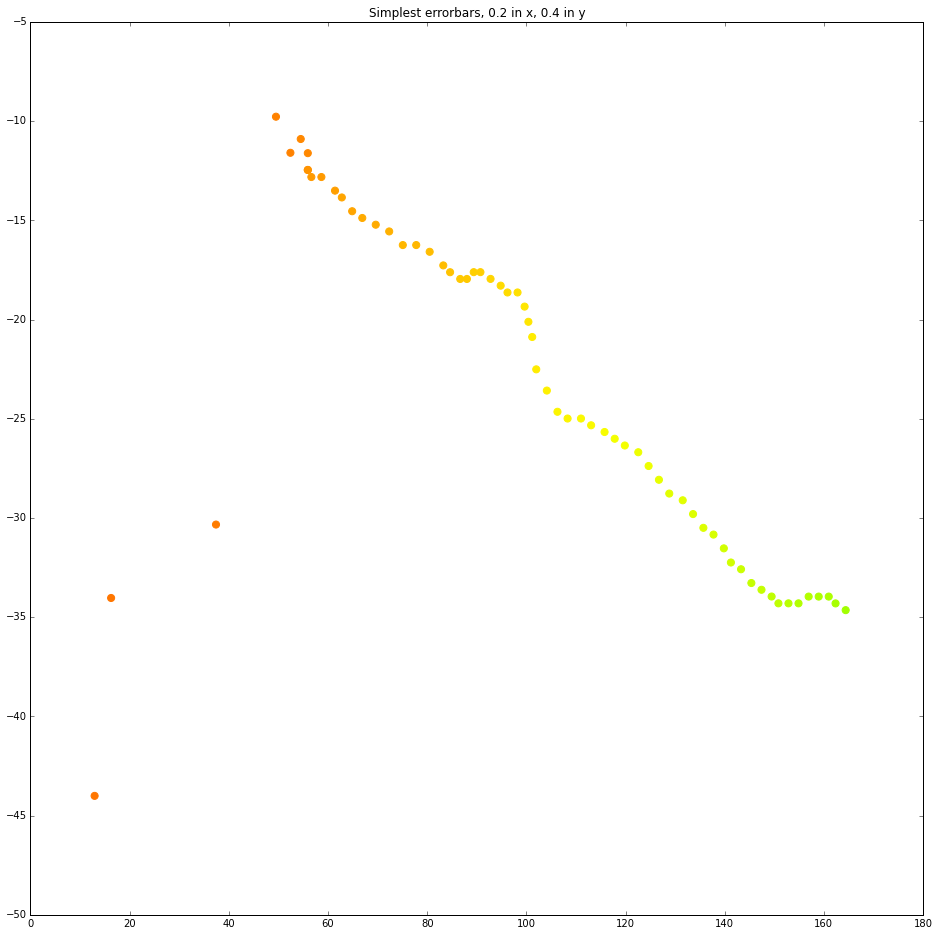

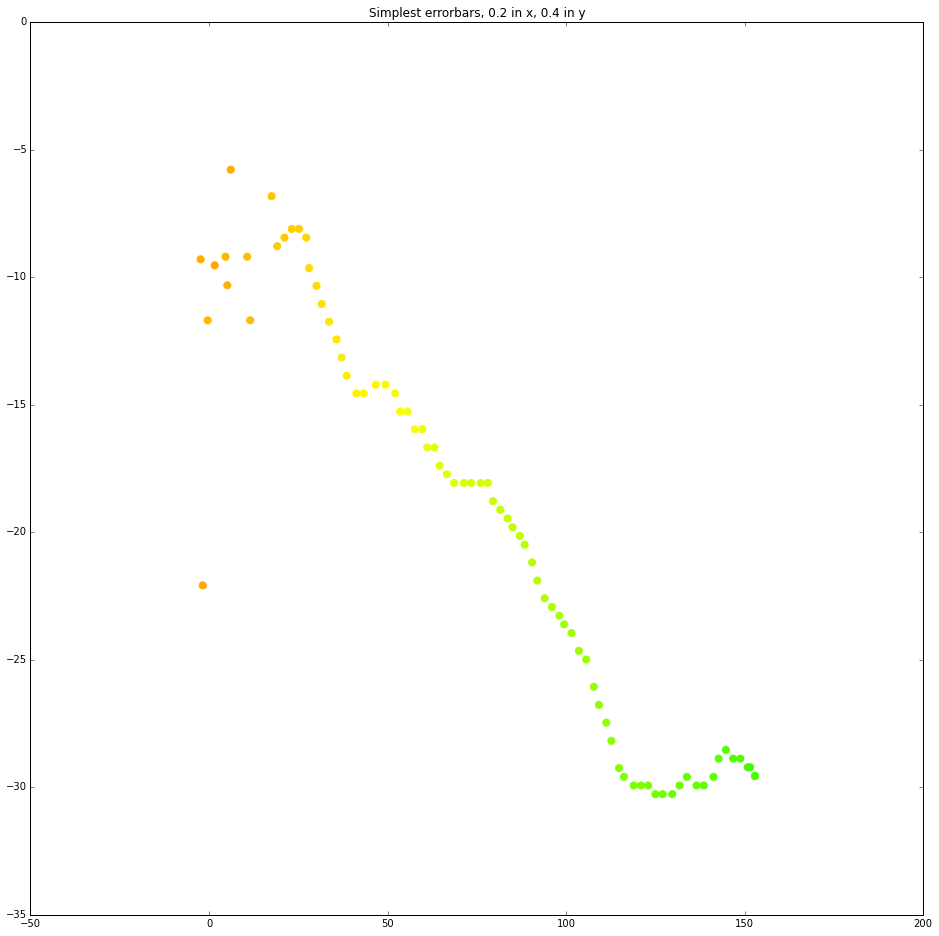

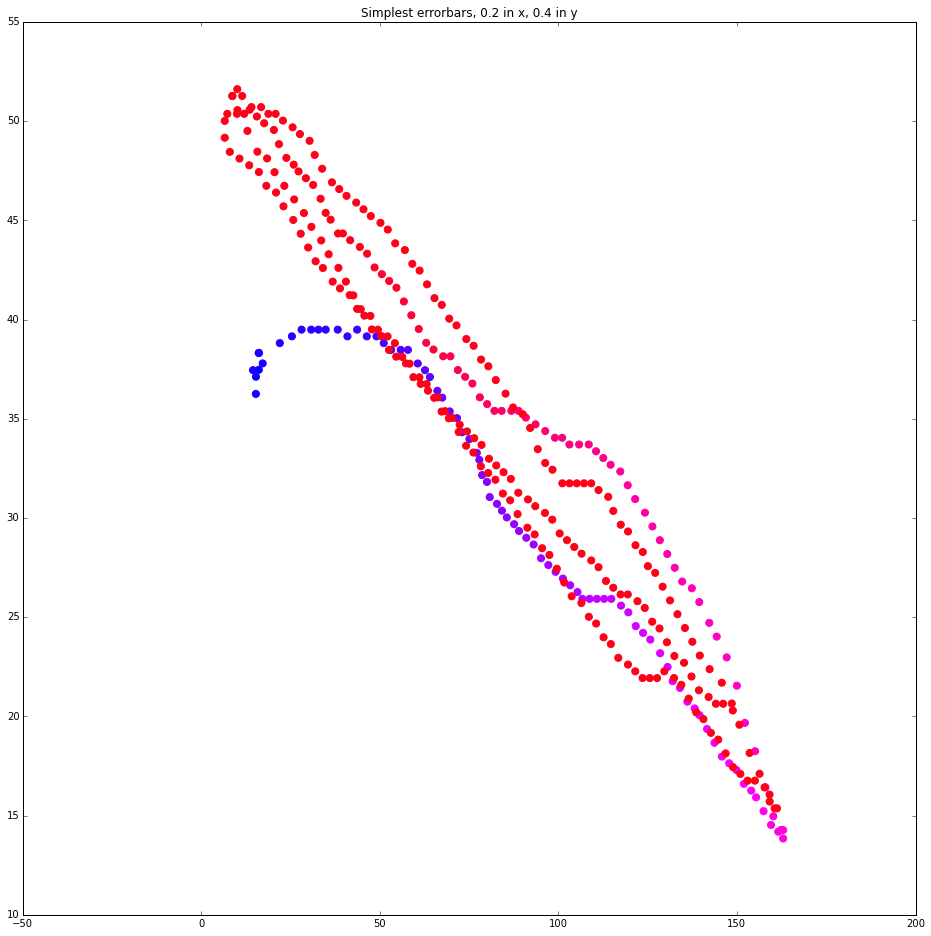

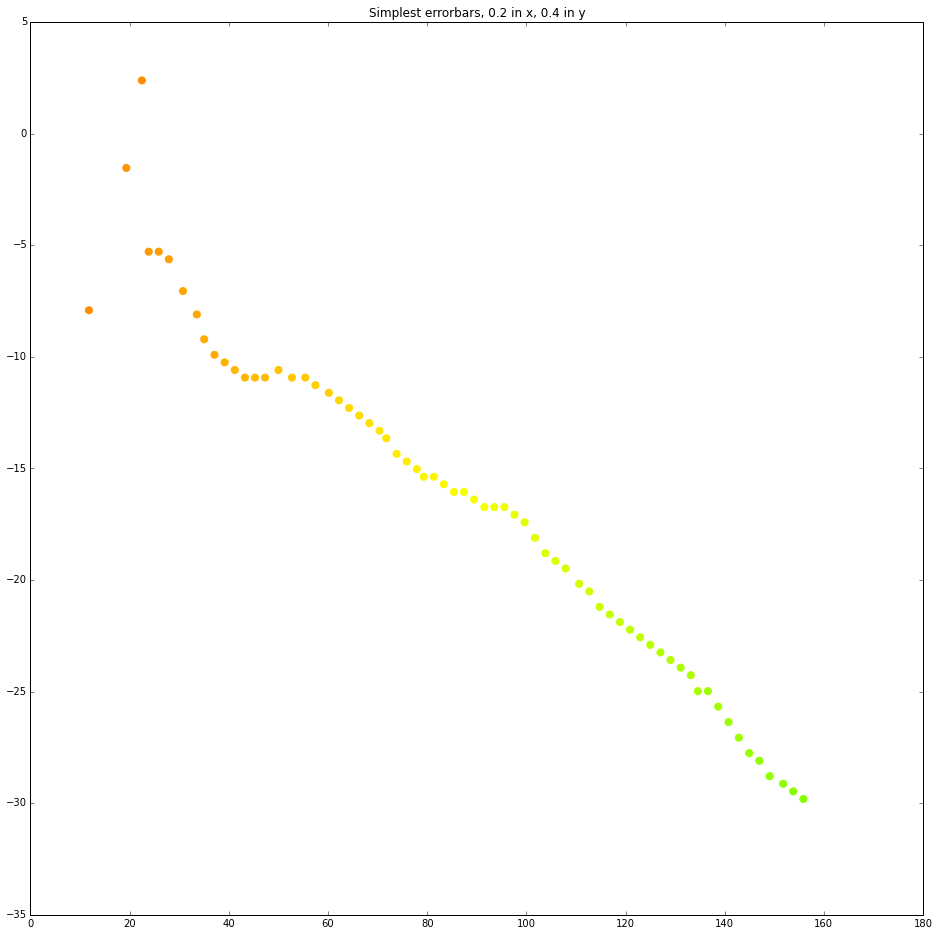

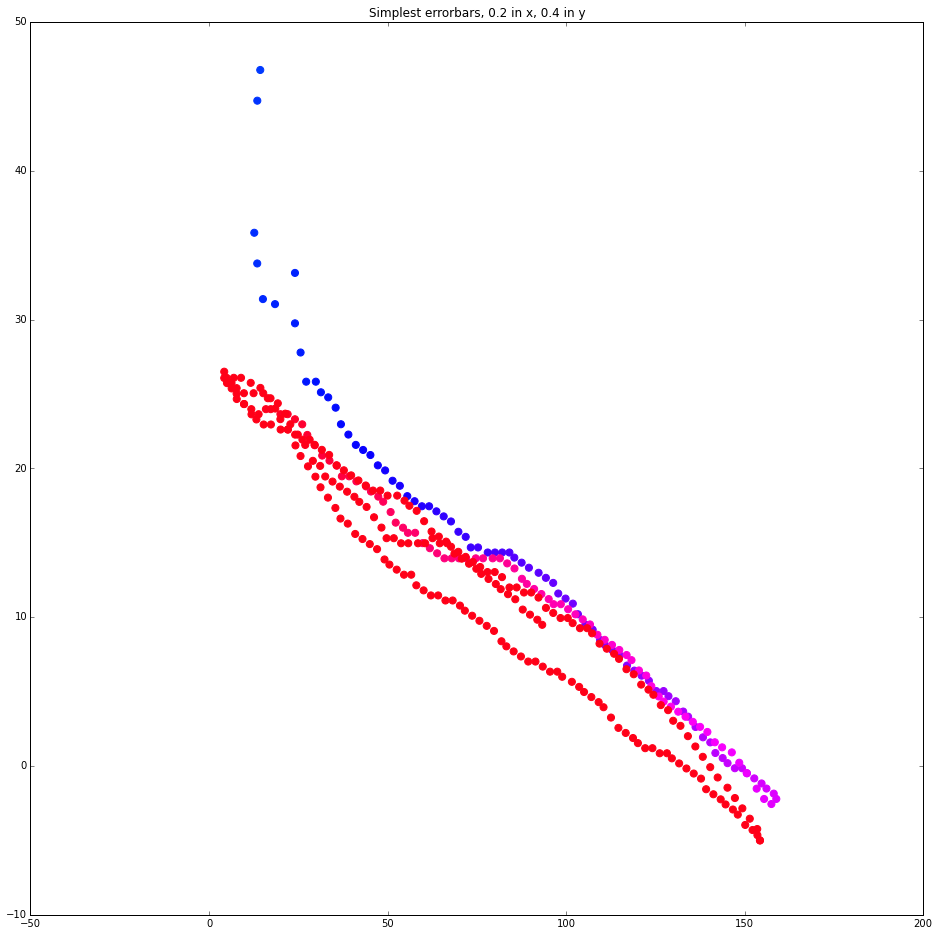

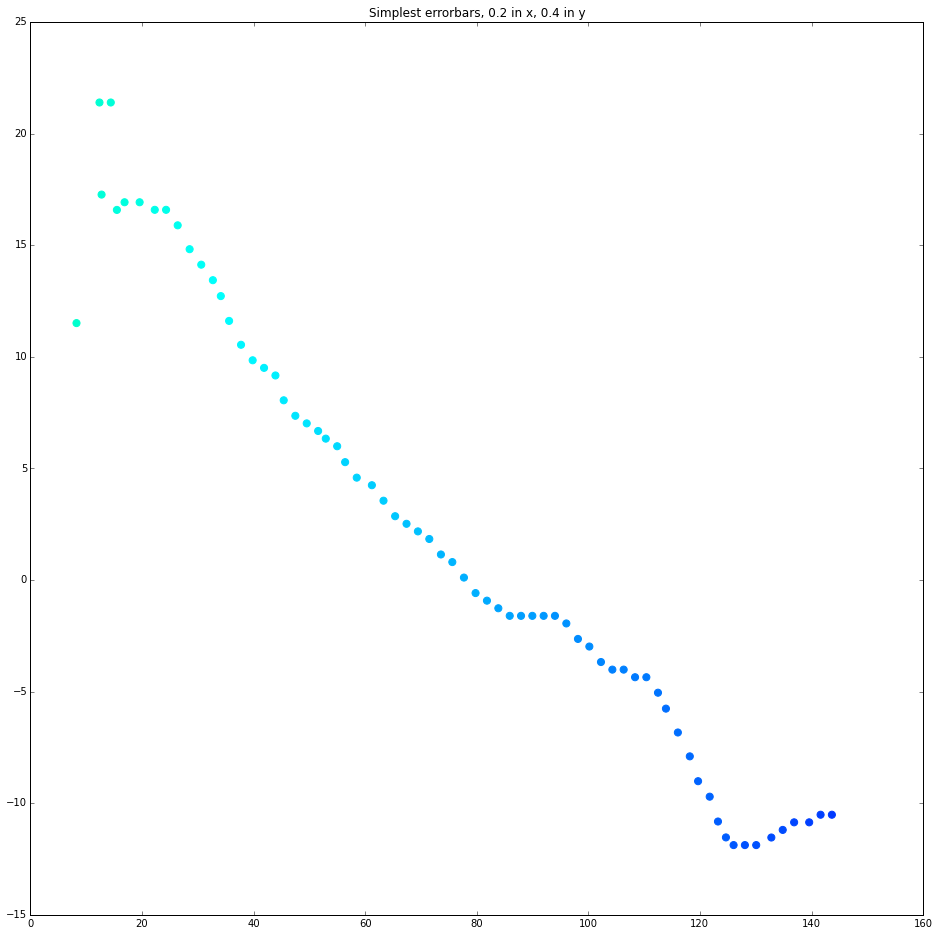

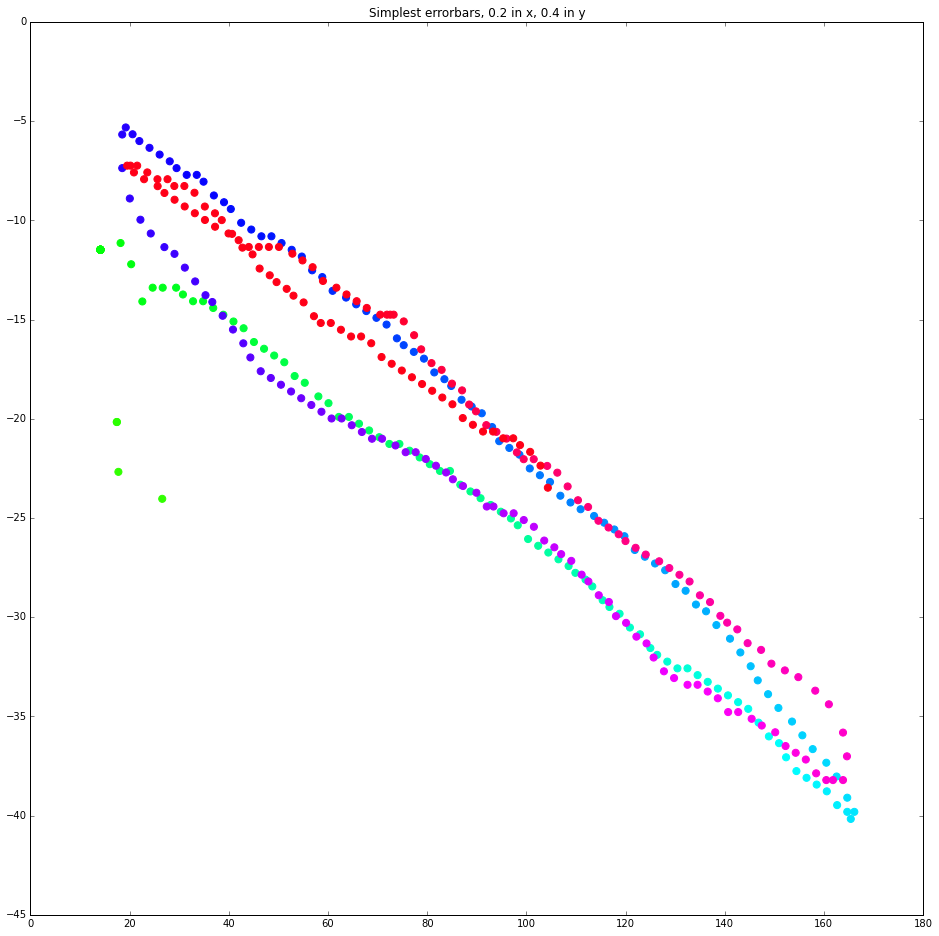

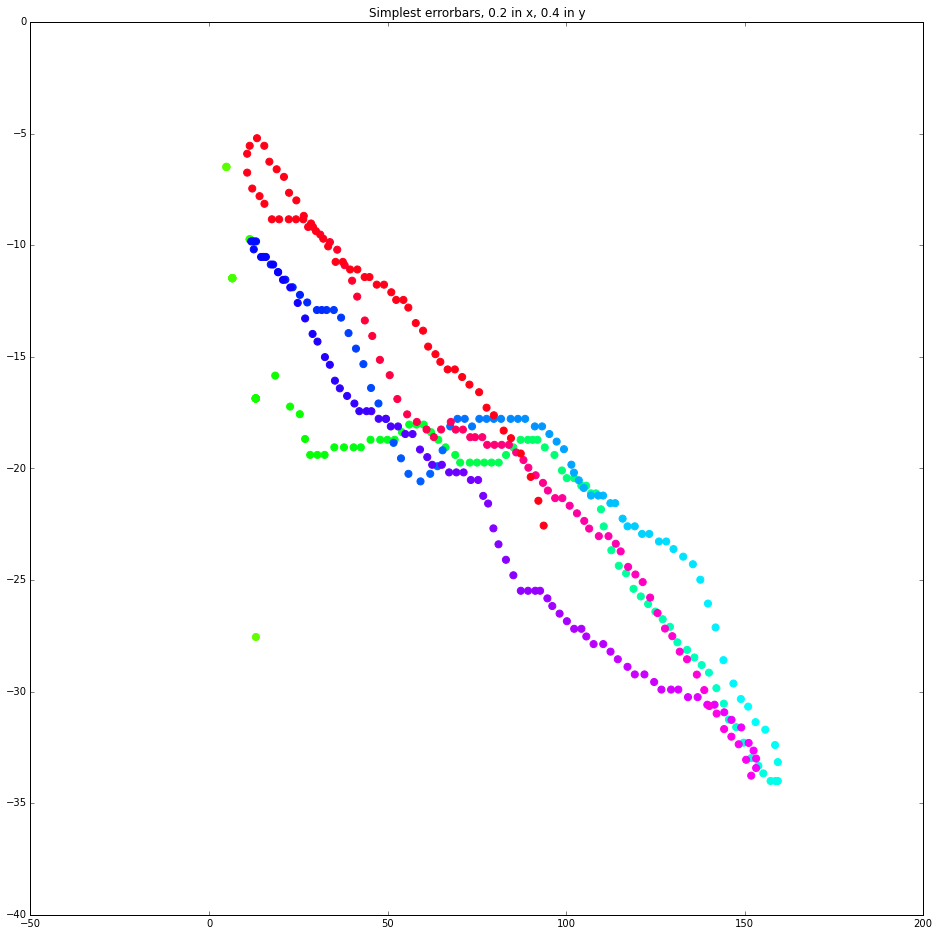

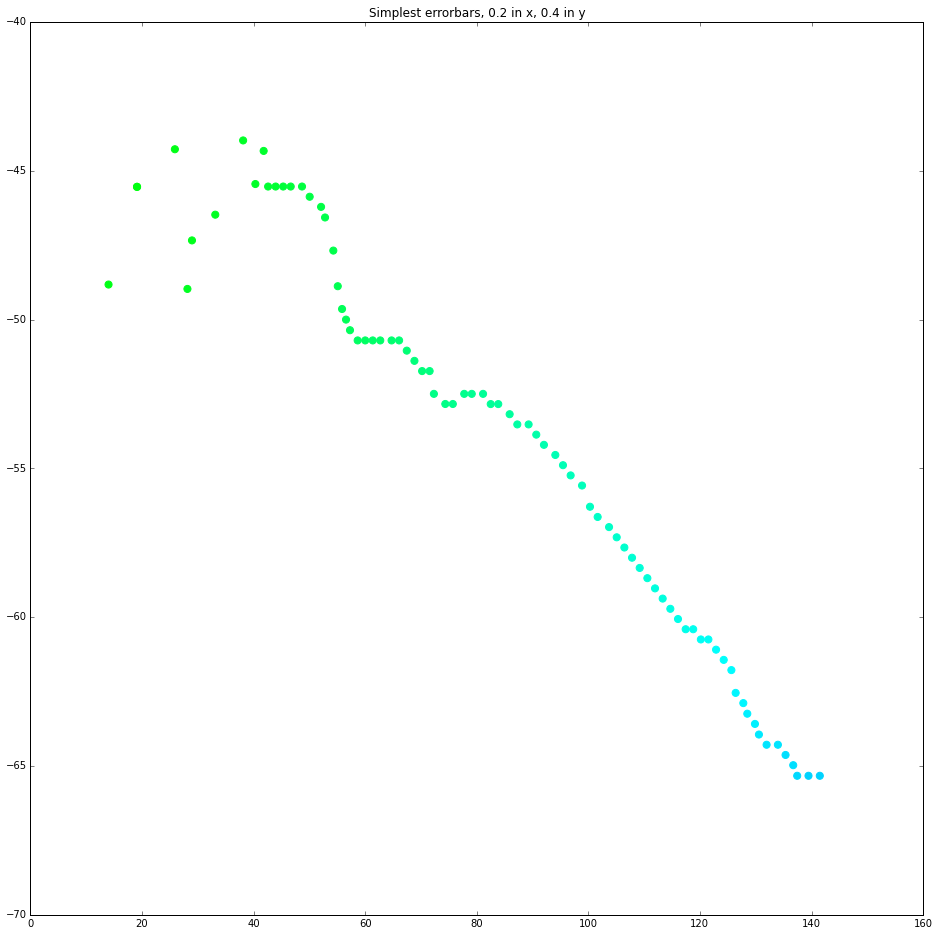

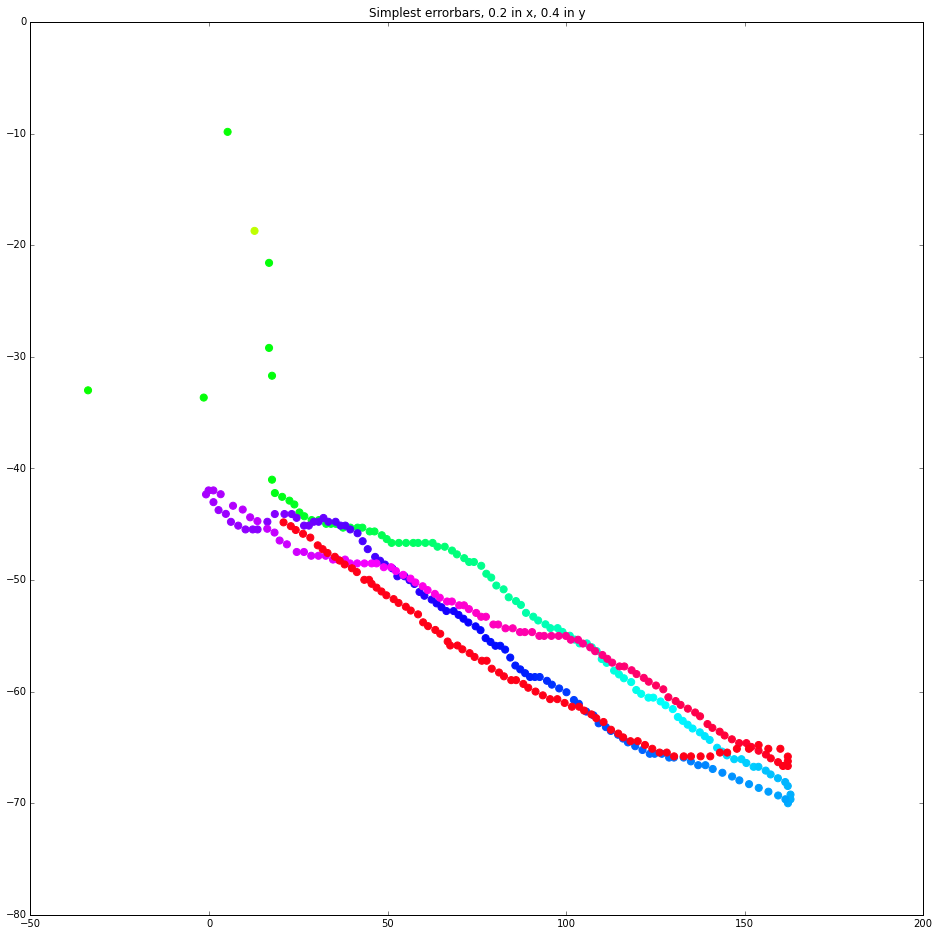

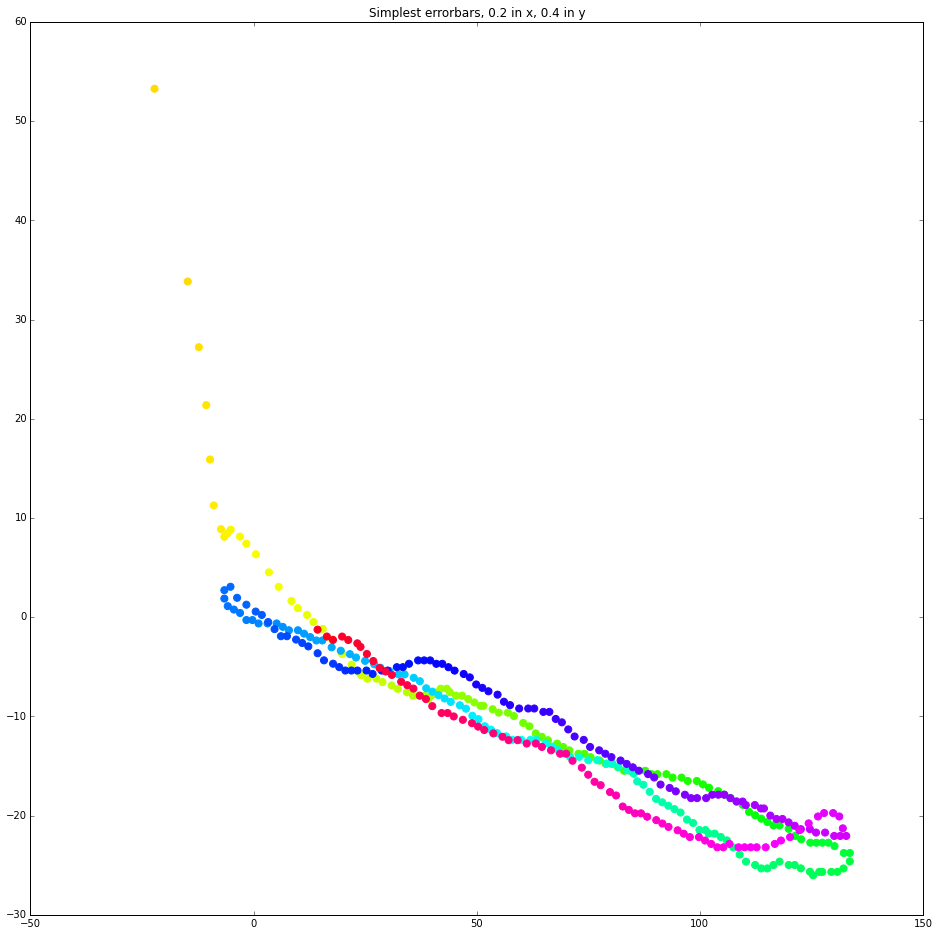

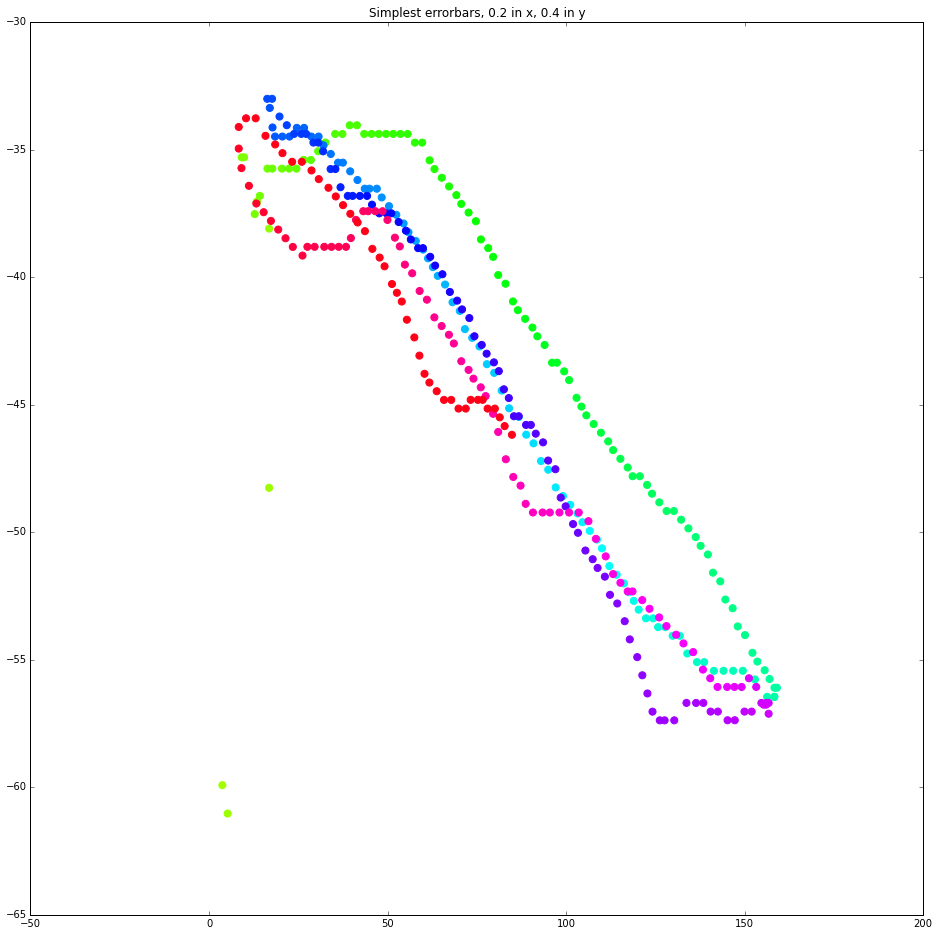

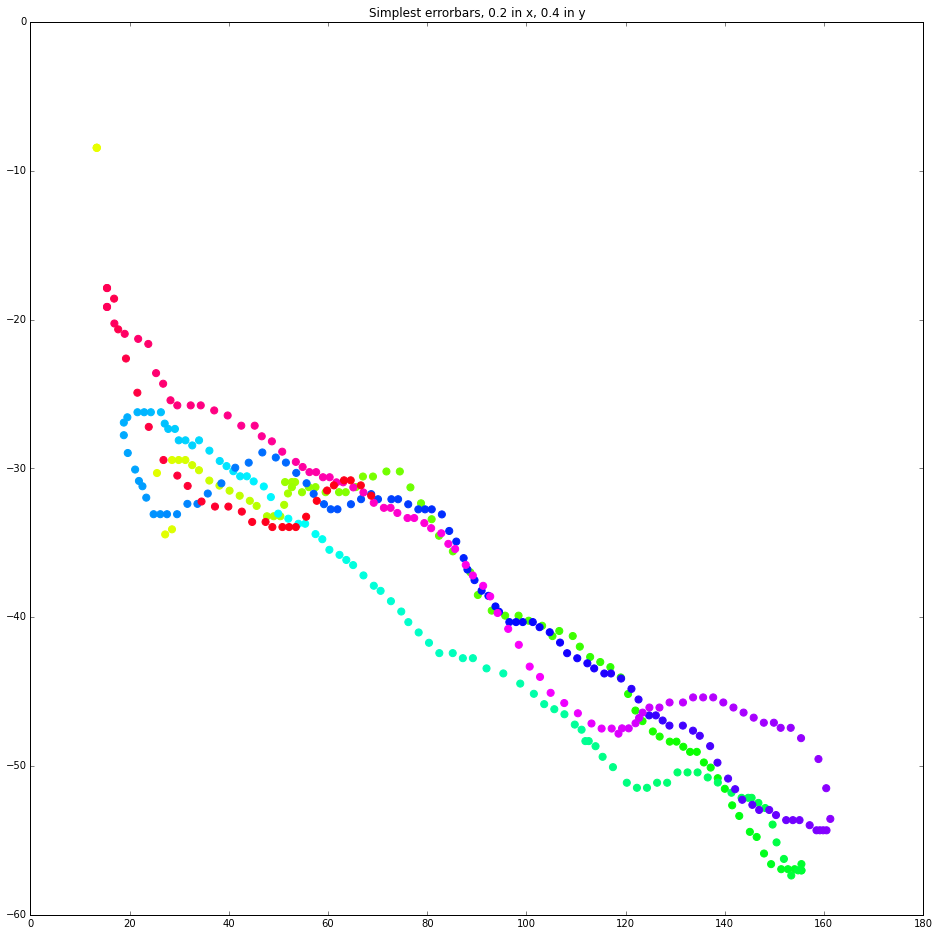

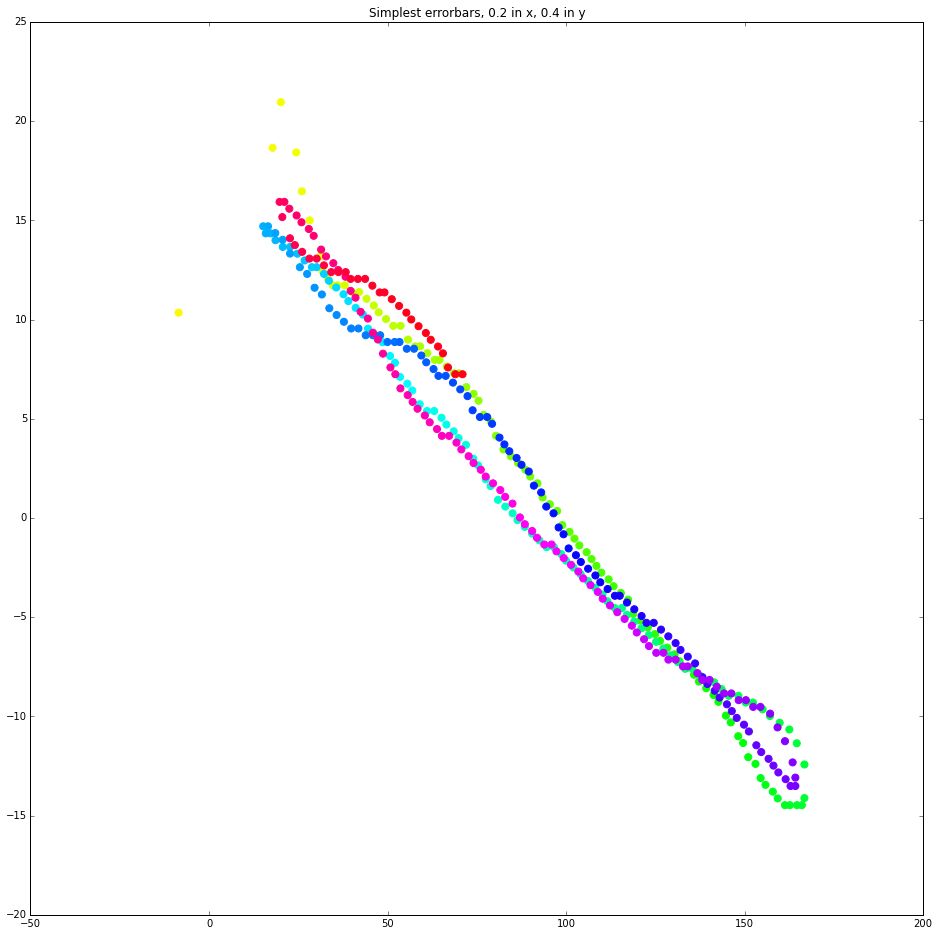

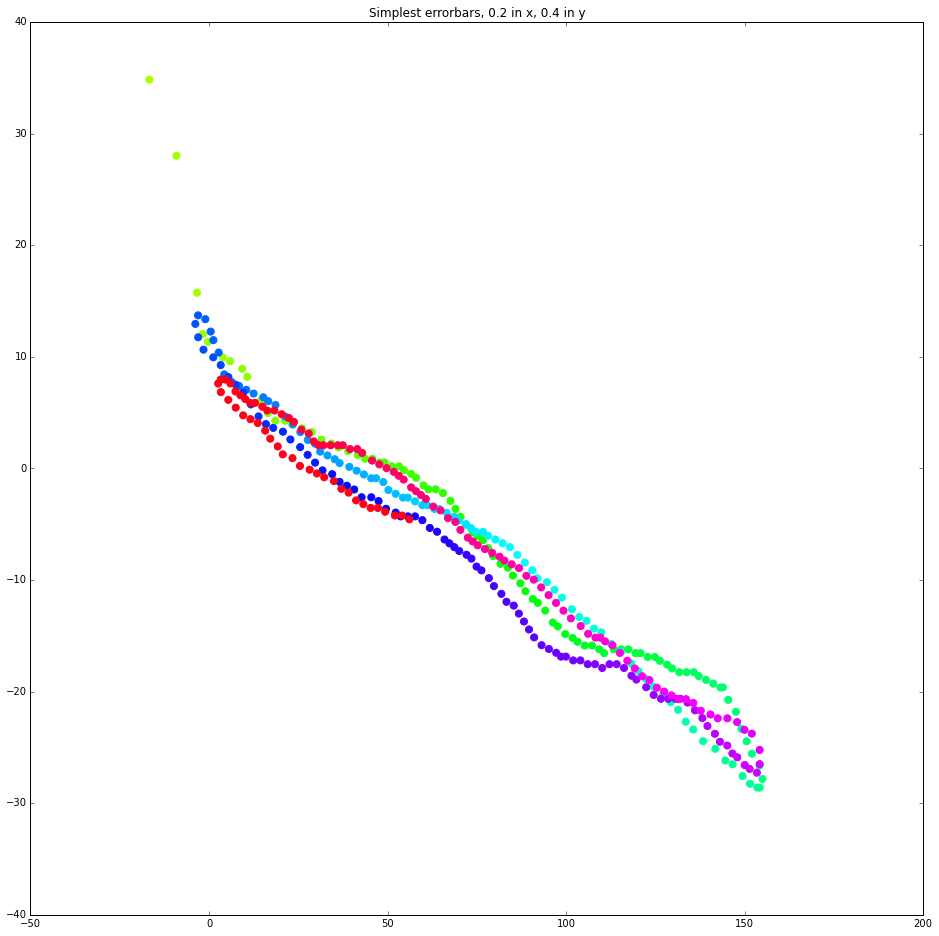

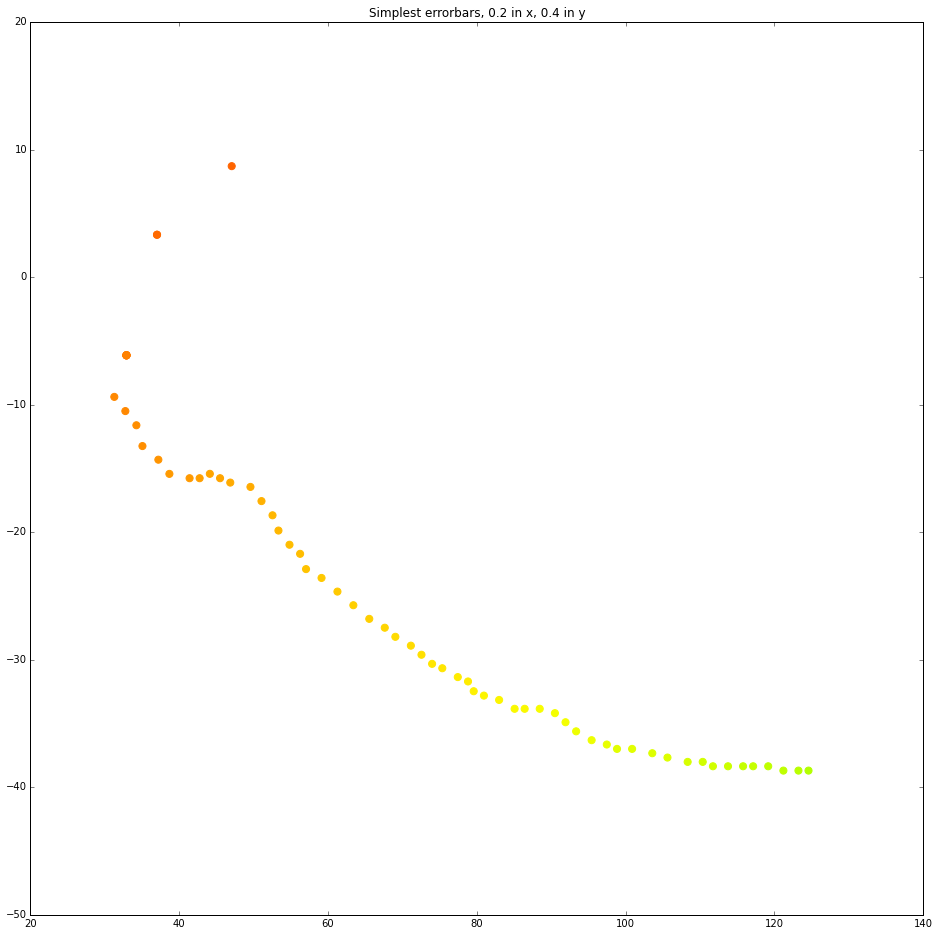

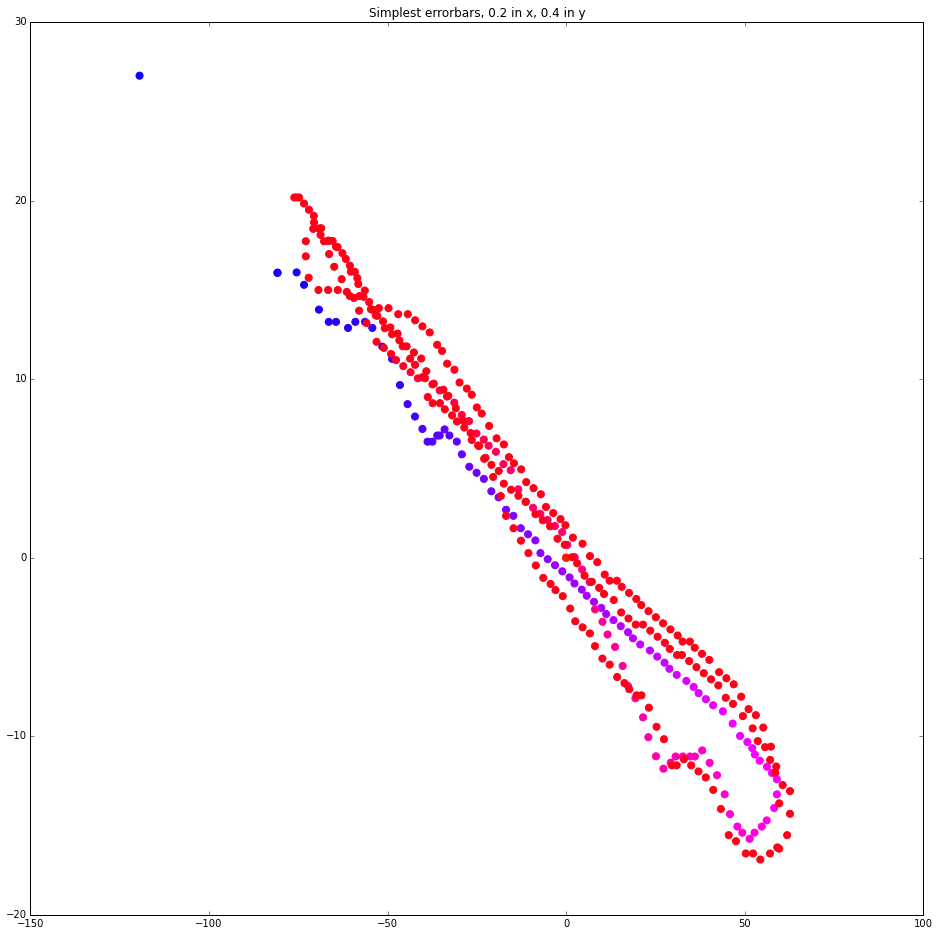

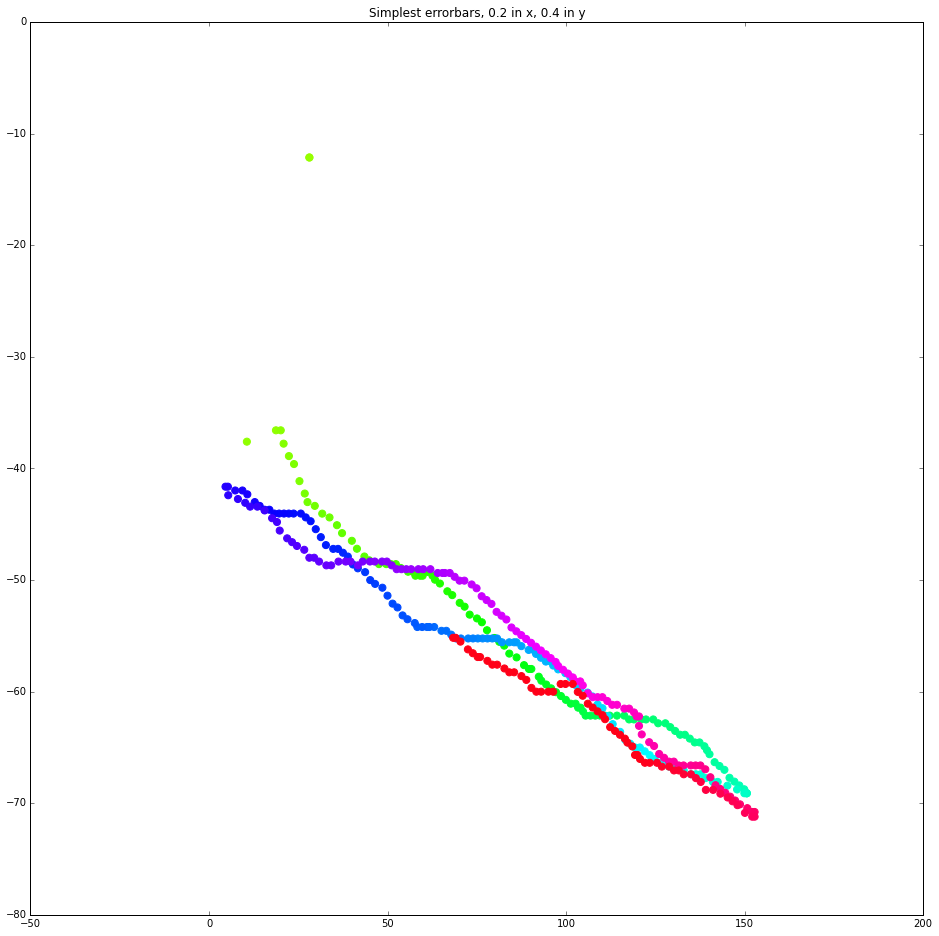

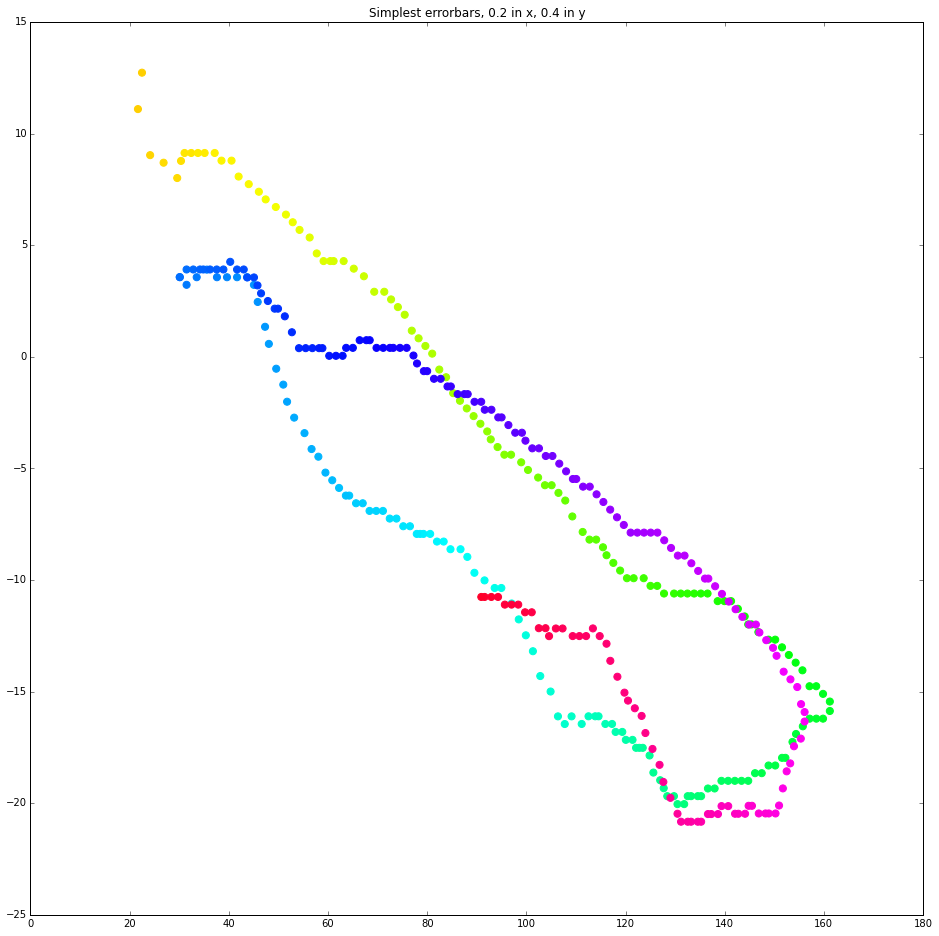

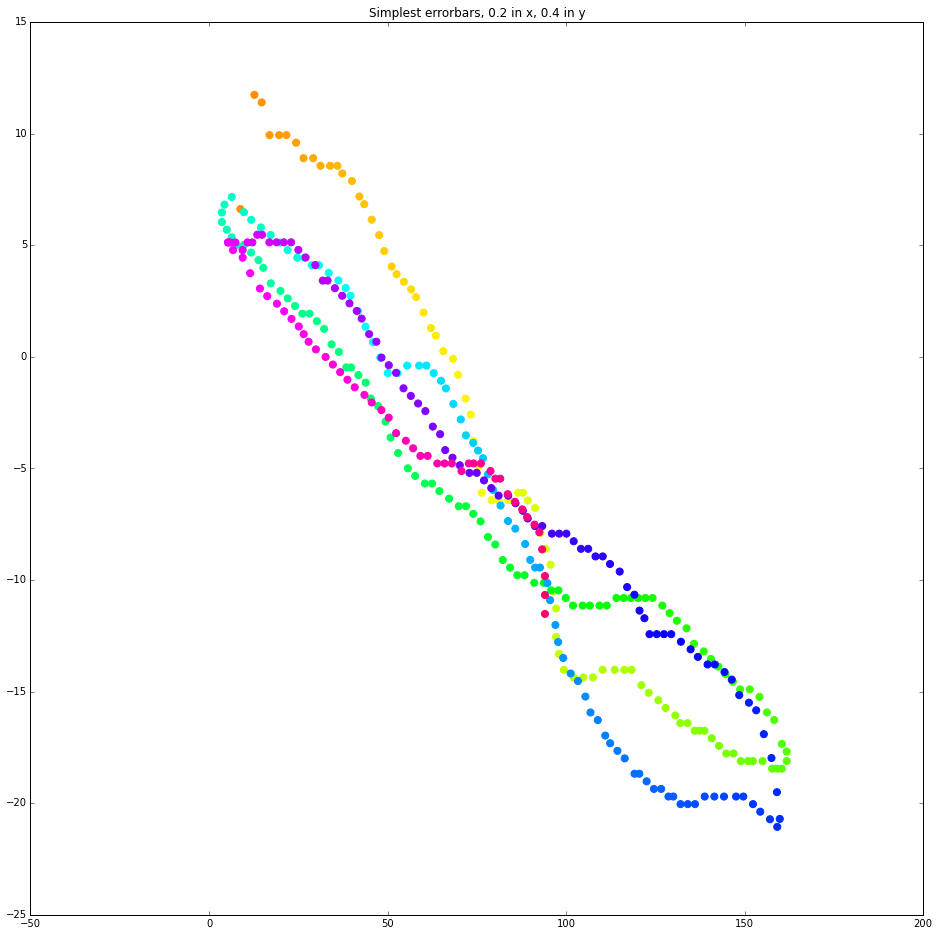

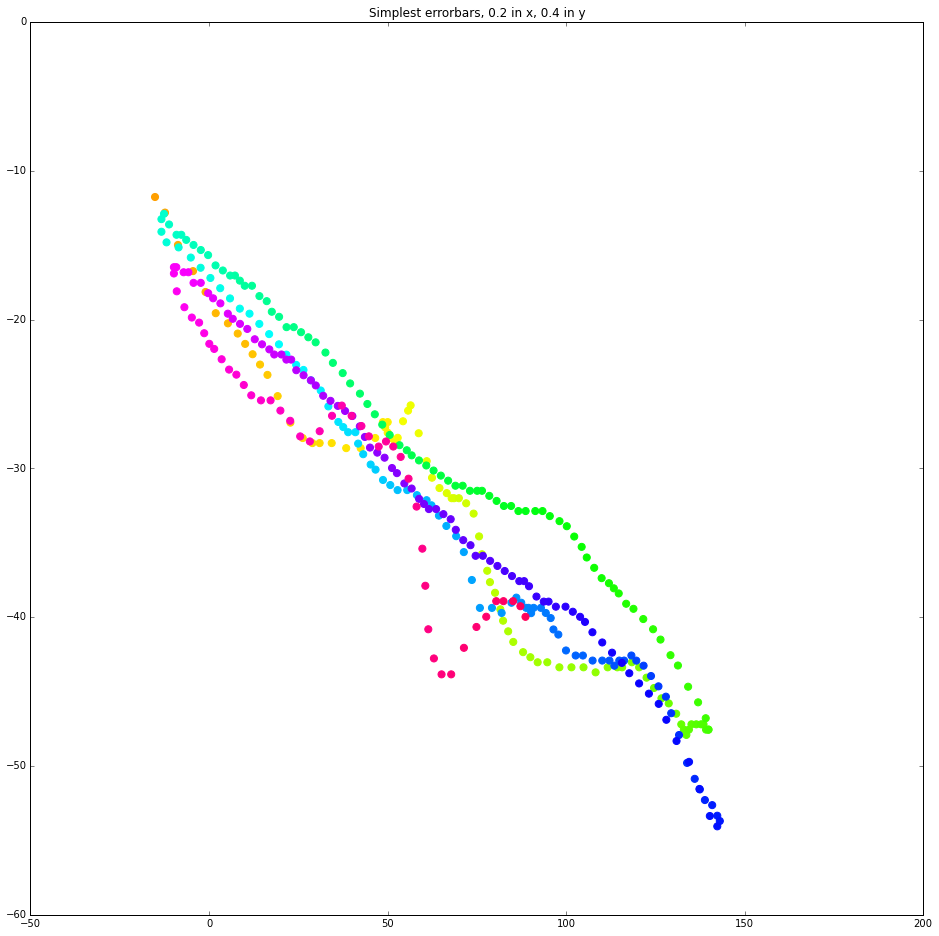

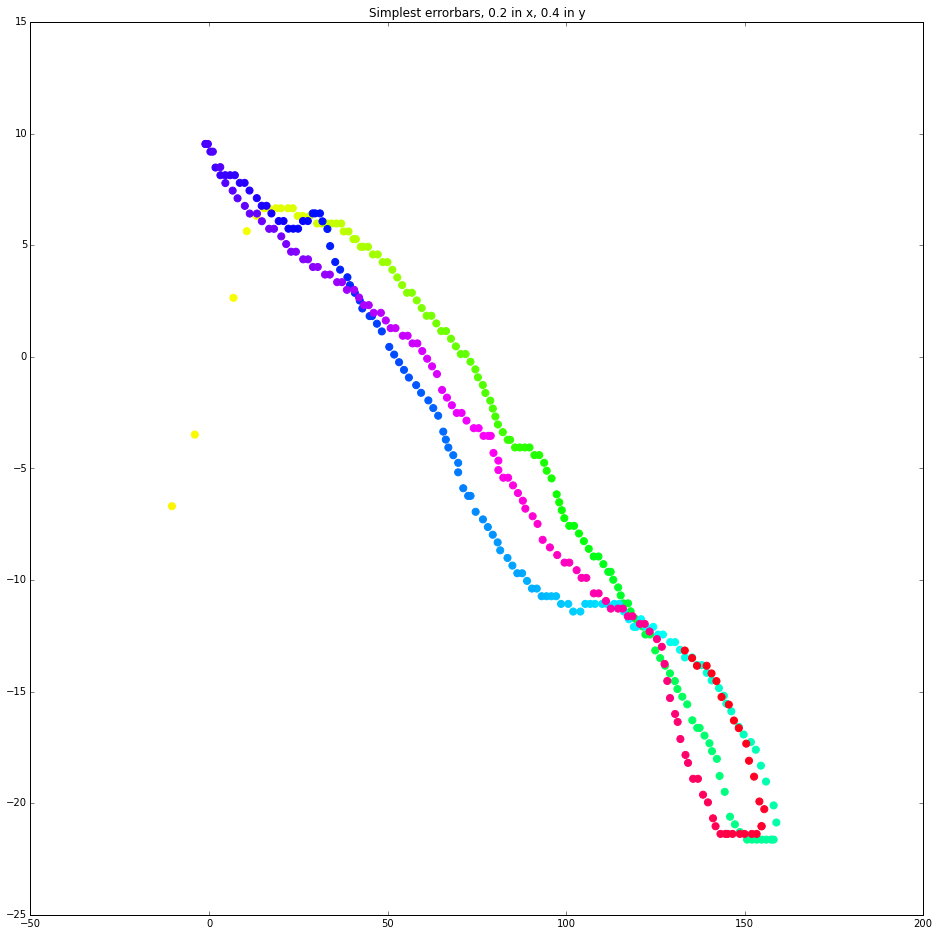

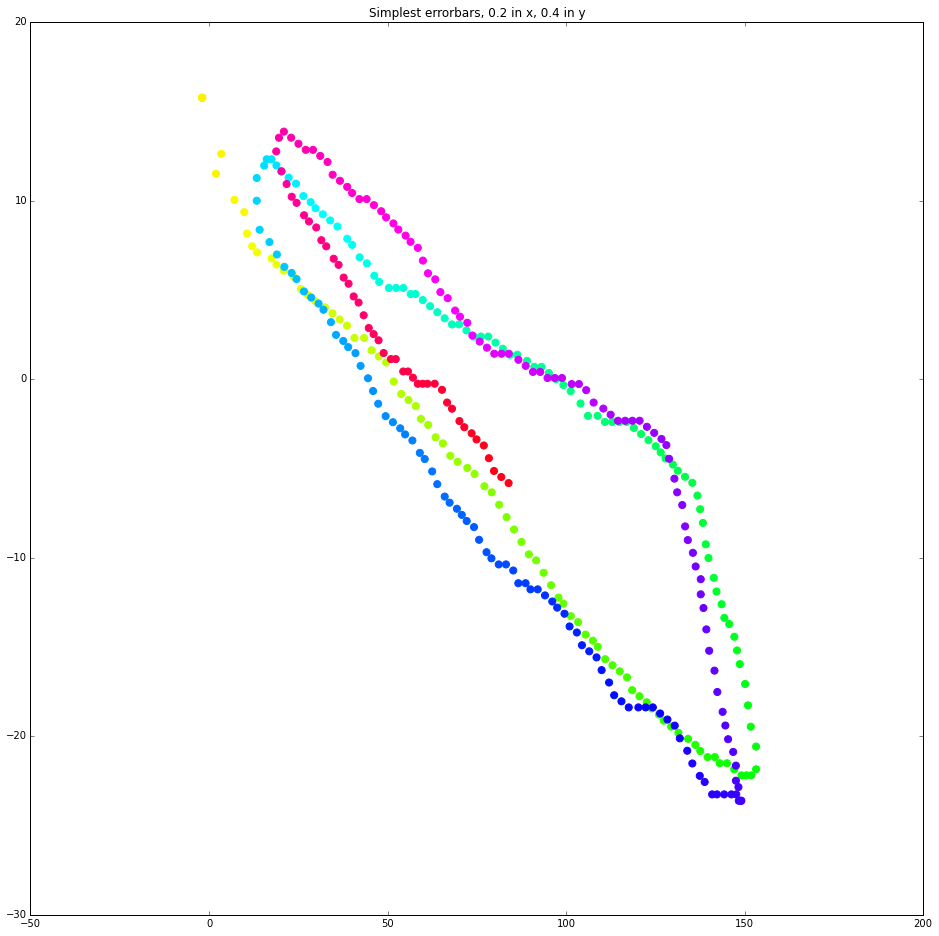

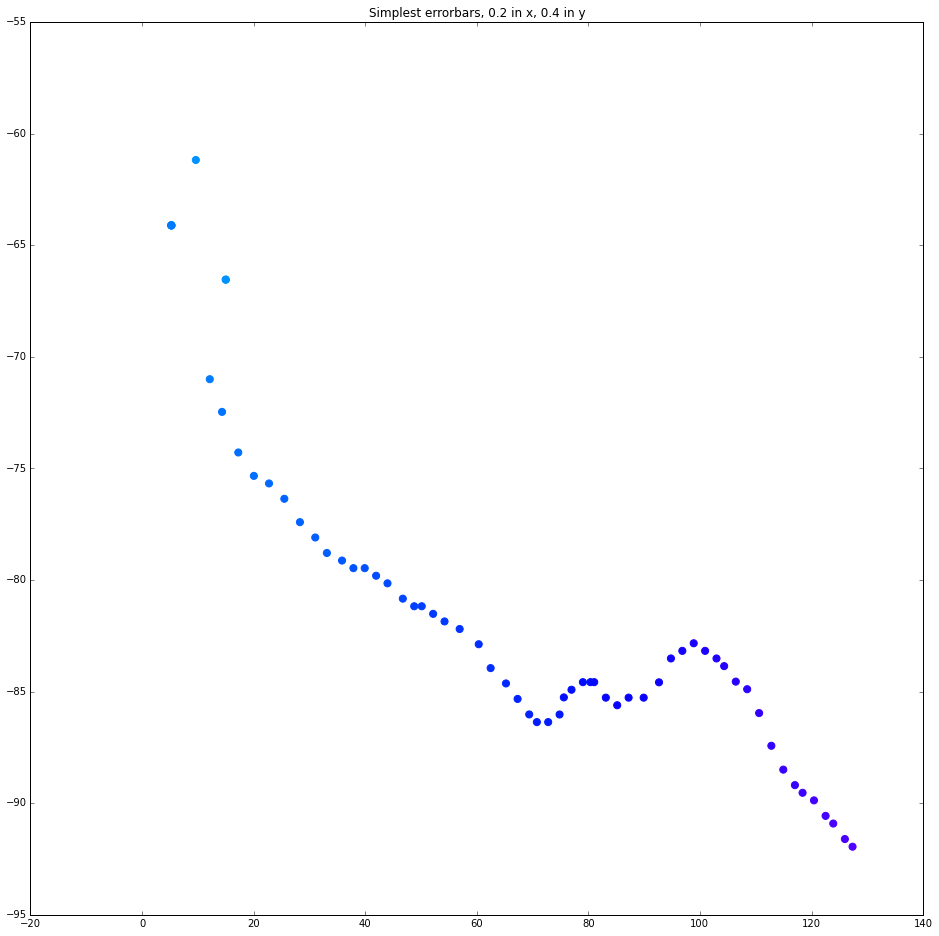

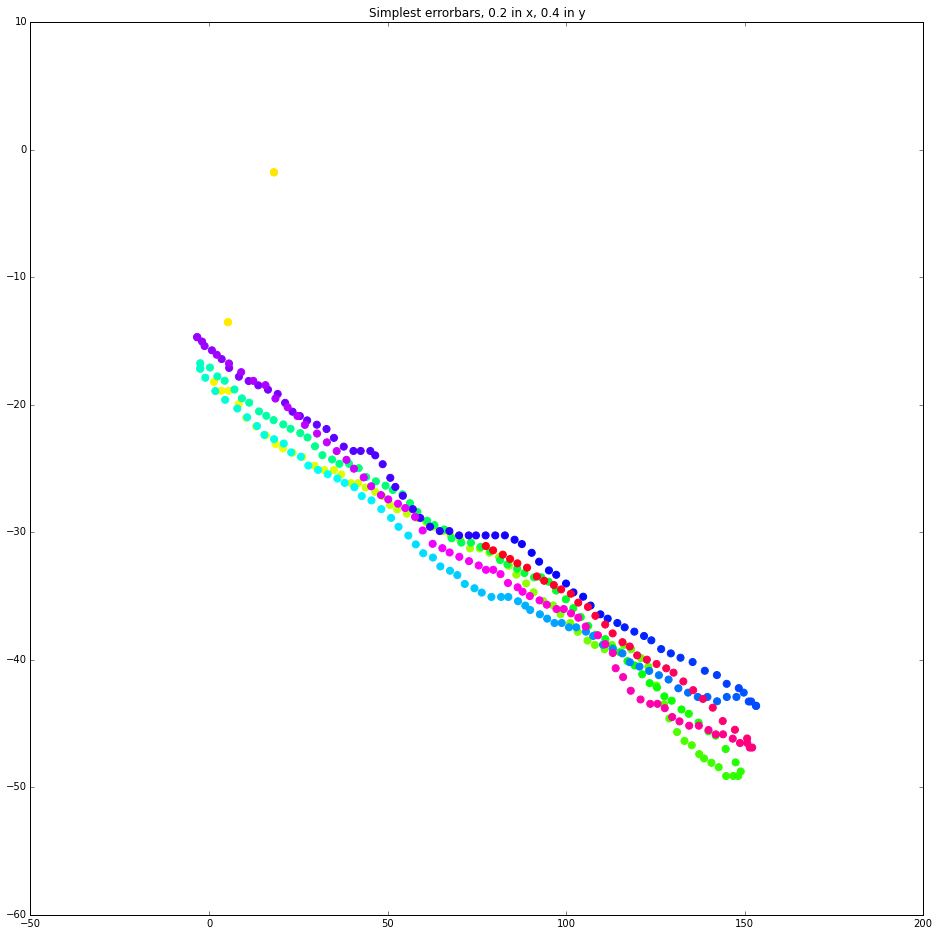

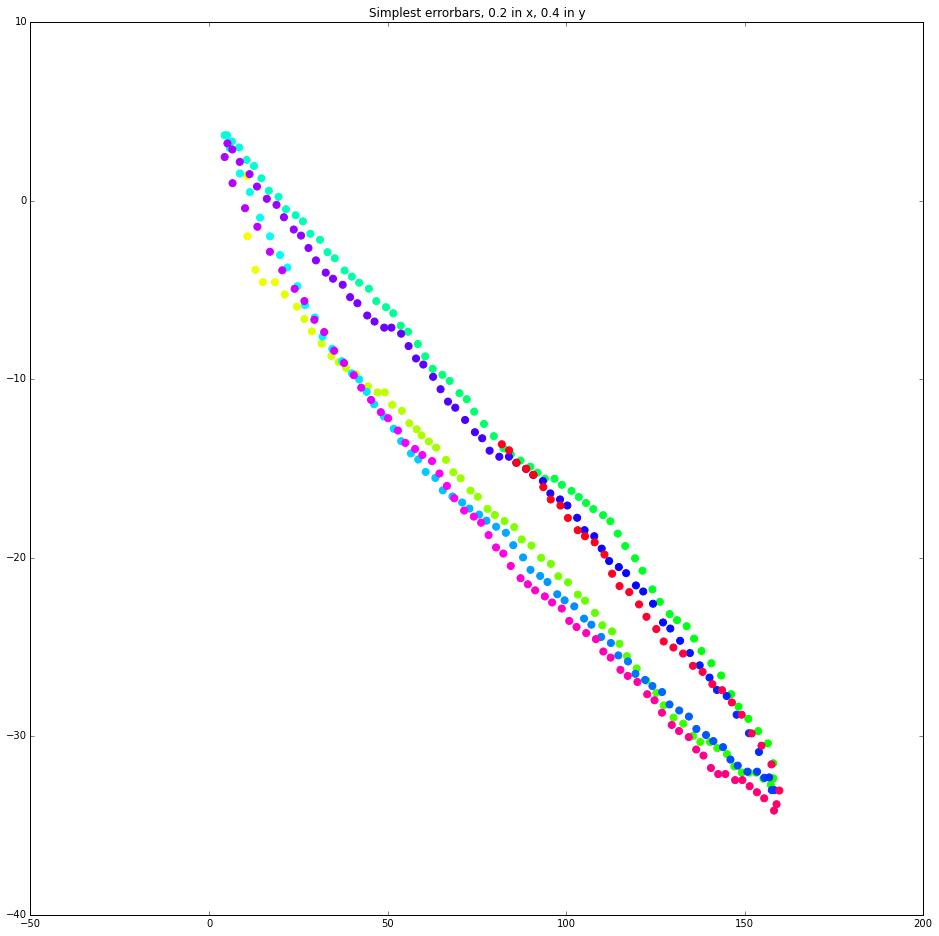

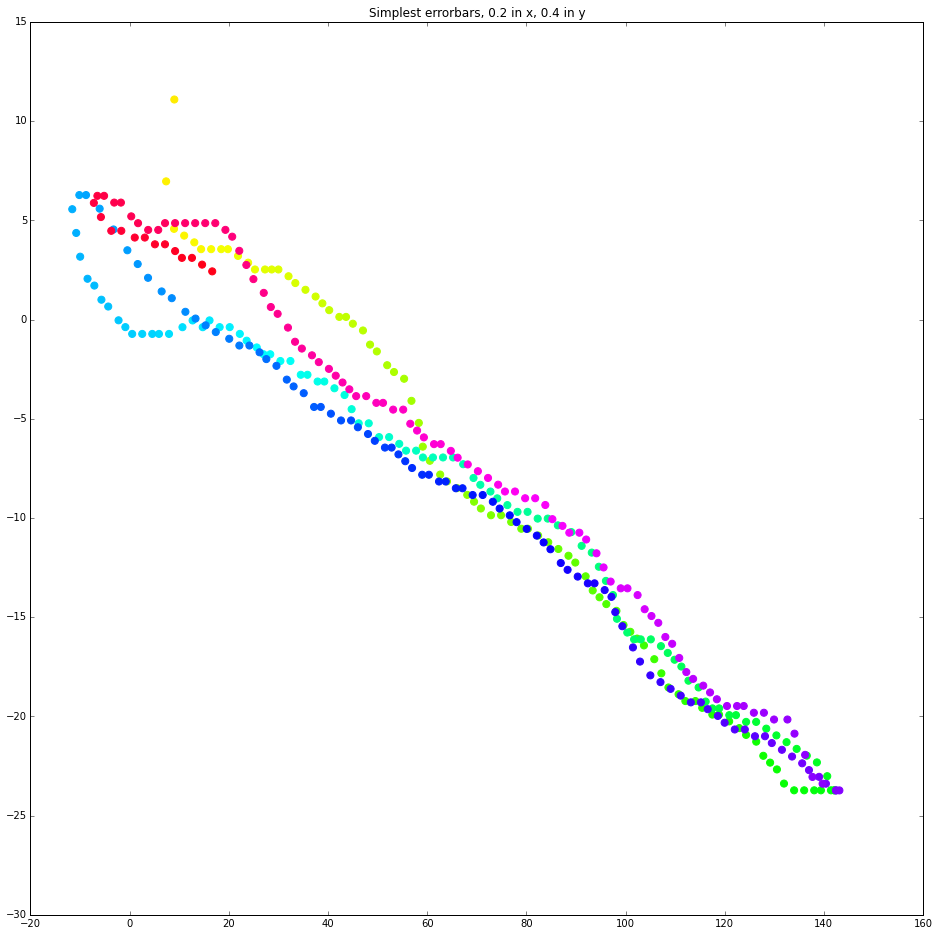

In [30]:
# Plot reconstructed path from one device
for row in disp_df.iterrows():
    print row[1]["phoneInfo"]
    plot = DistPlot(join(base_path, "UnknownFile_1.json.items", str(row[1]["UnknownFile_1.json.items"])))

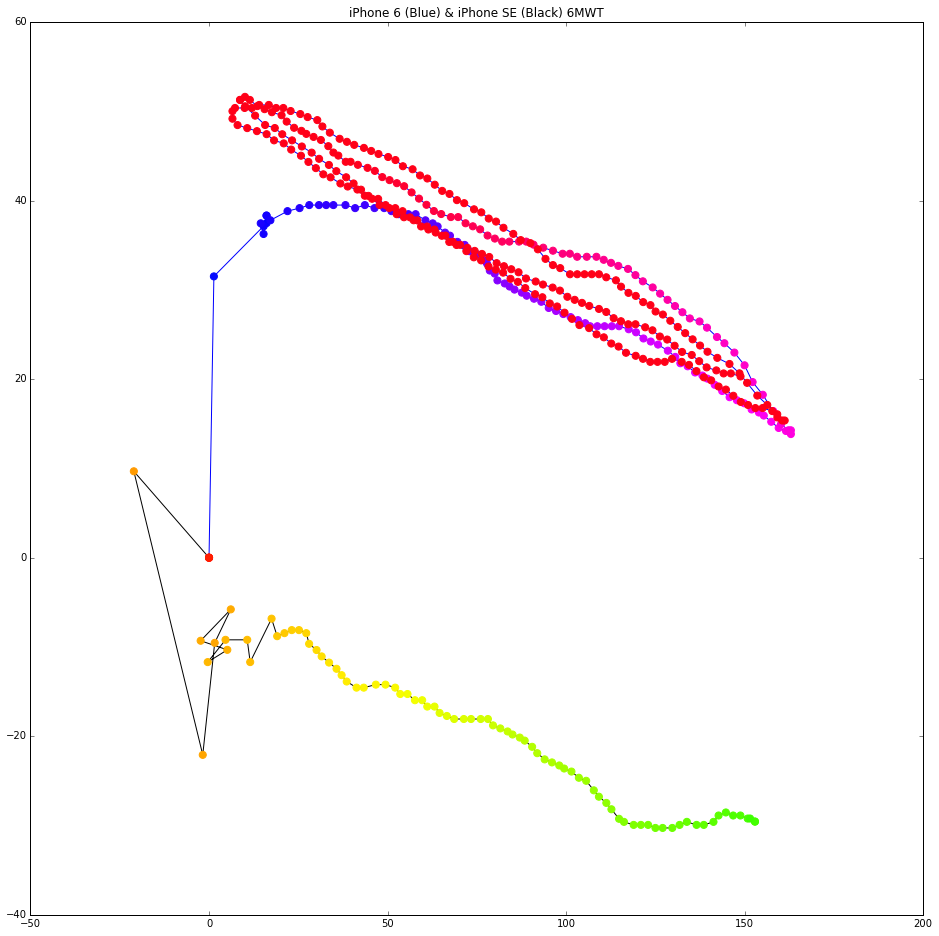

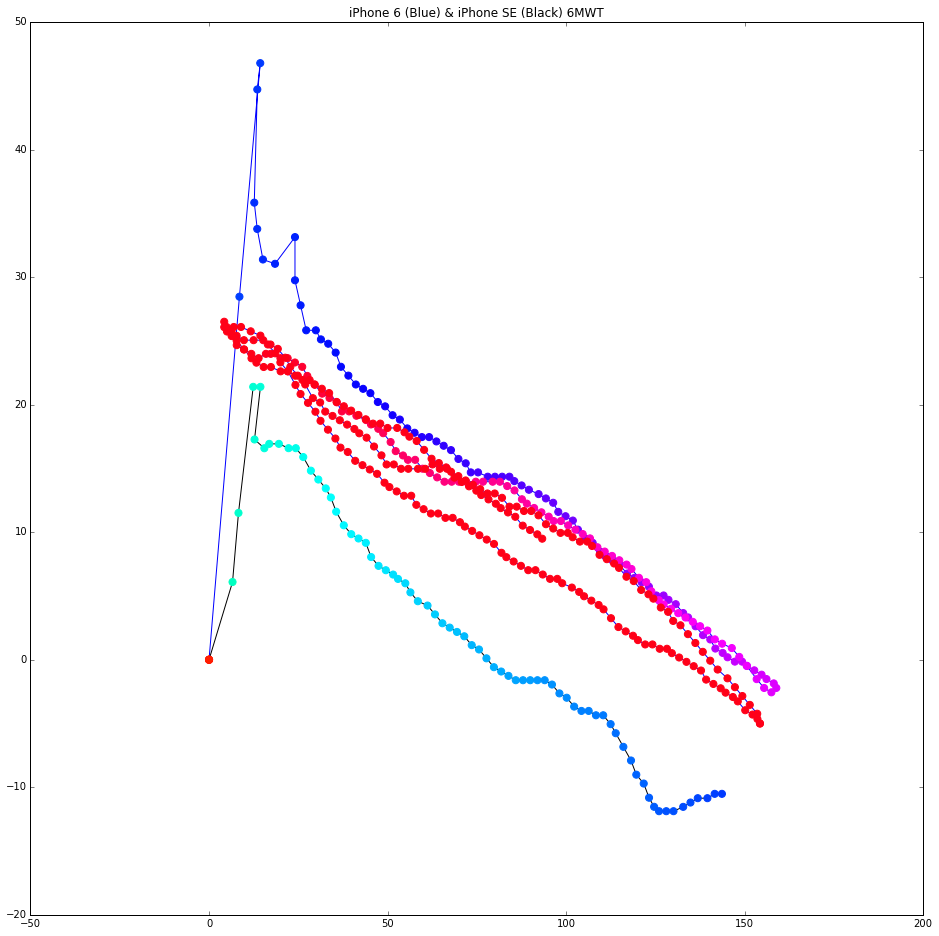

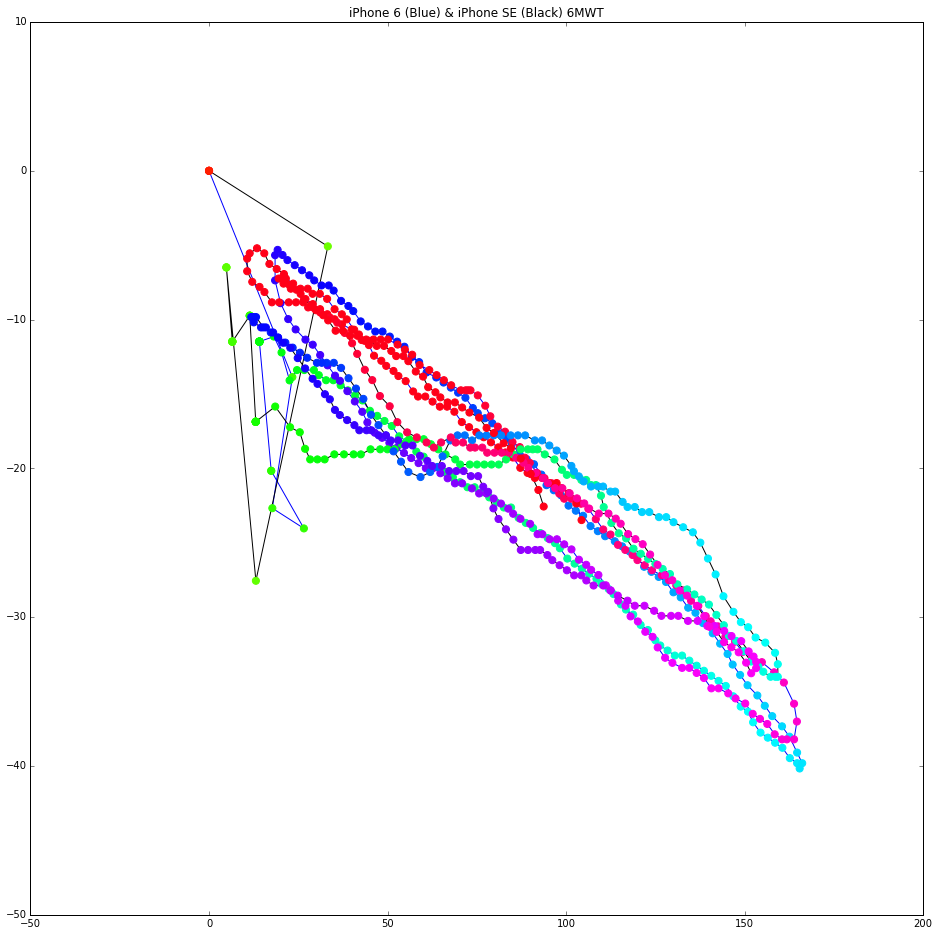

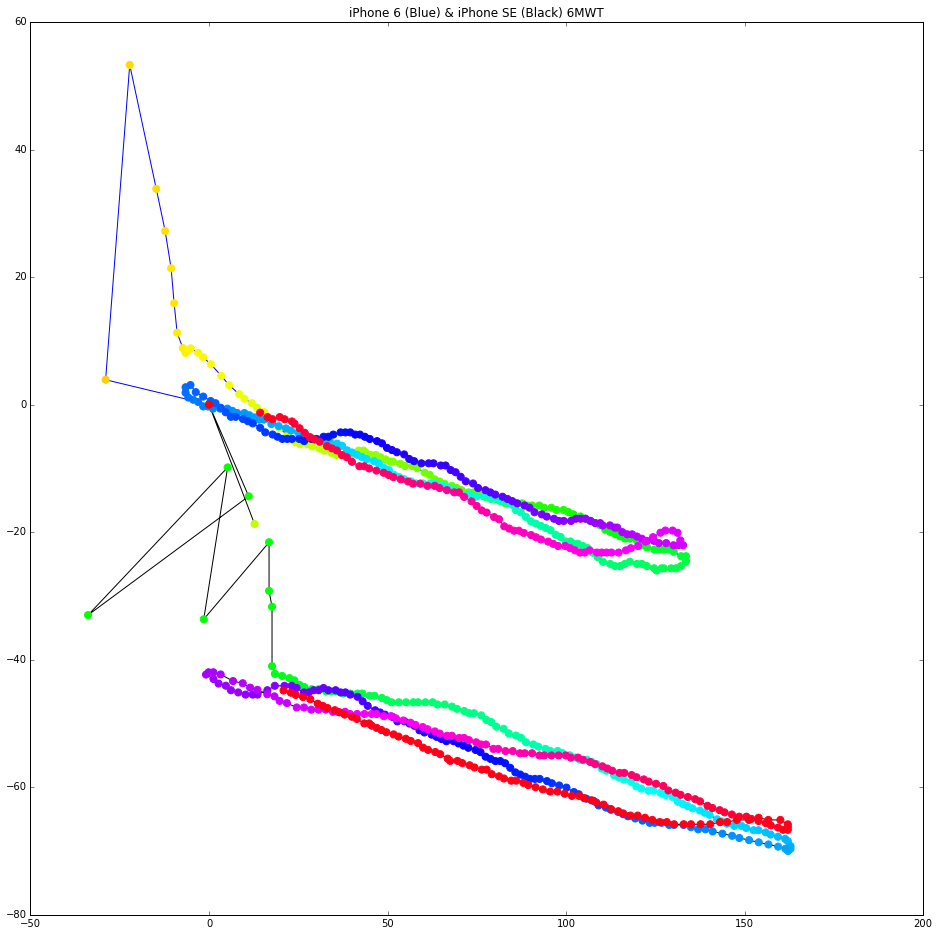

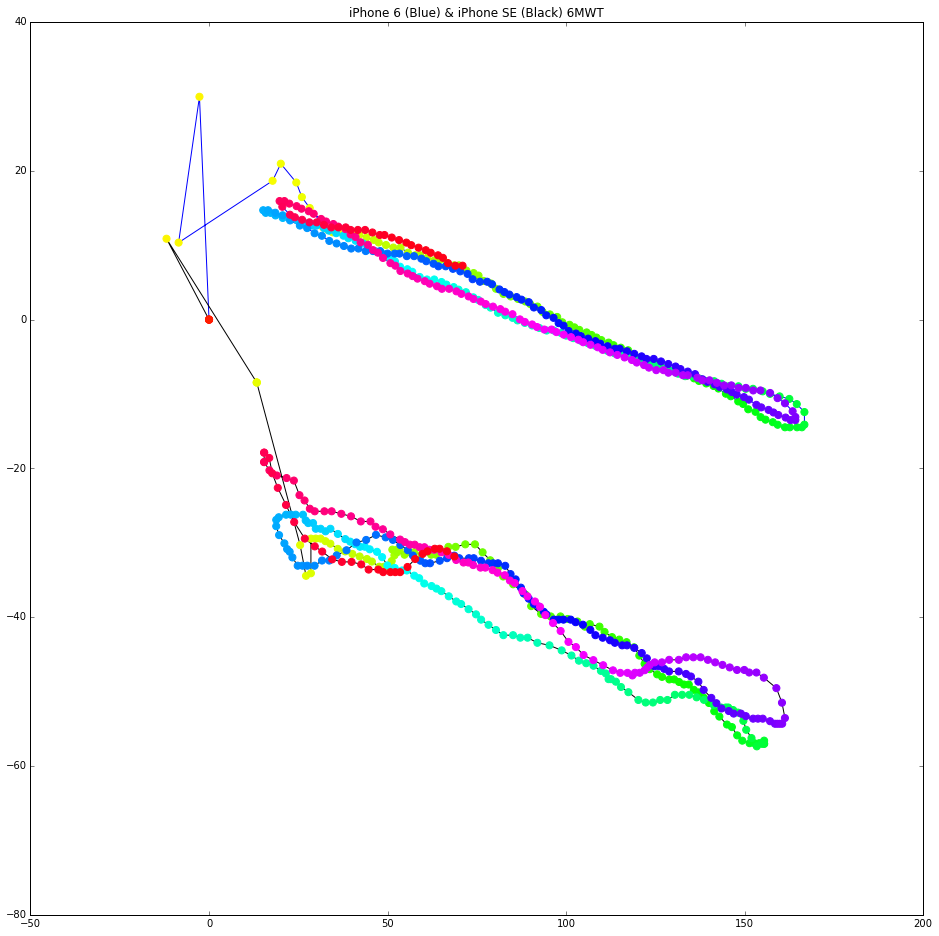

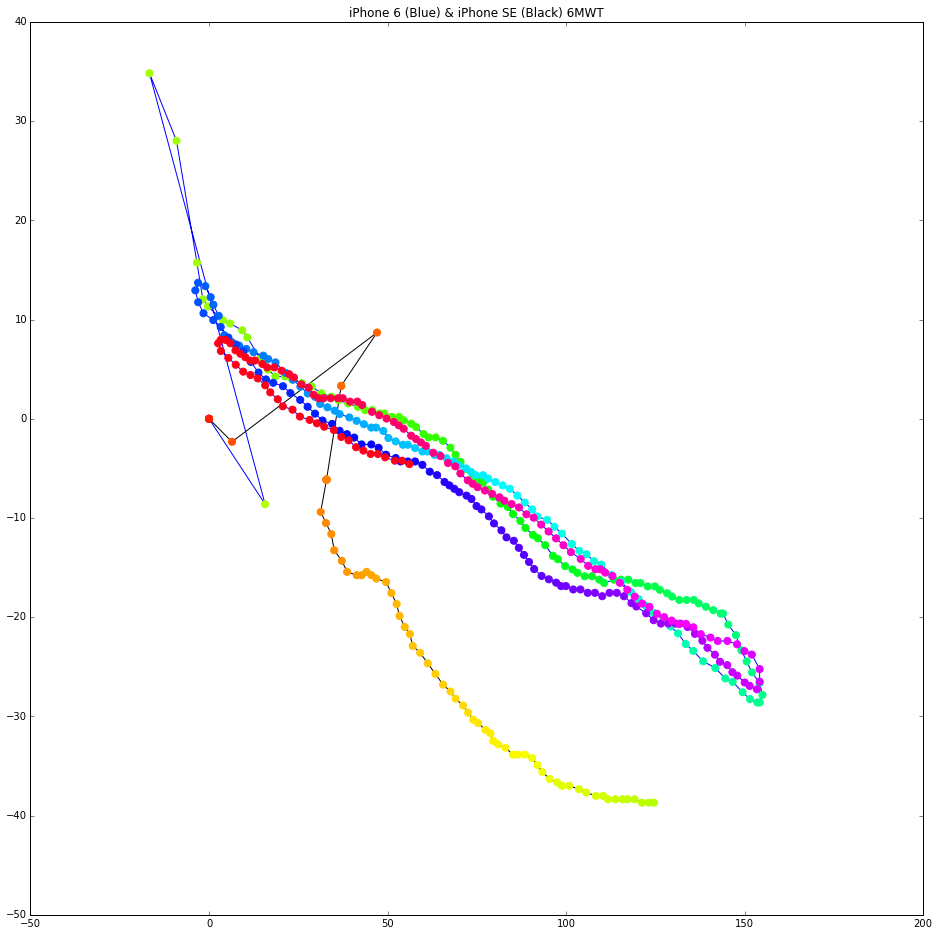

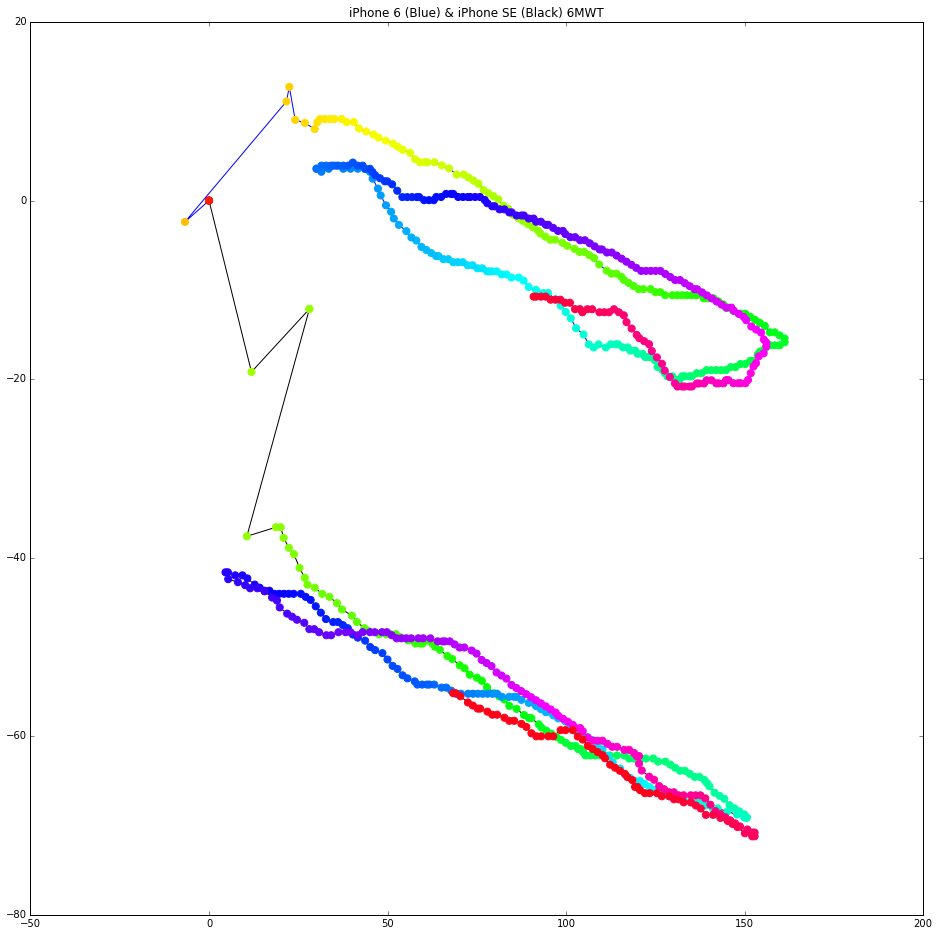

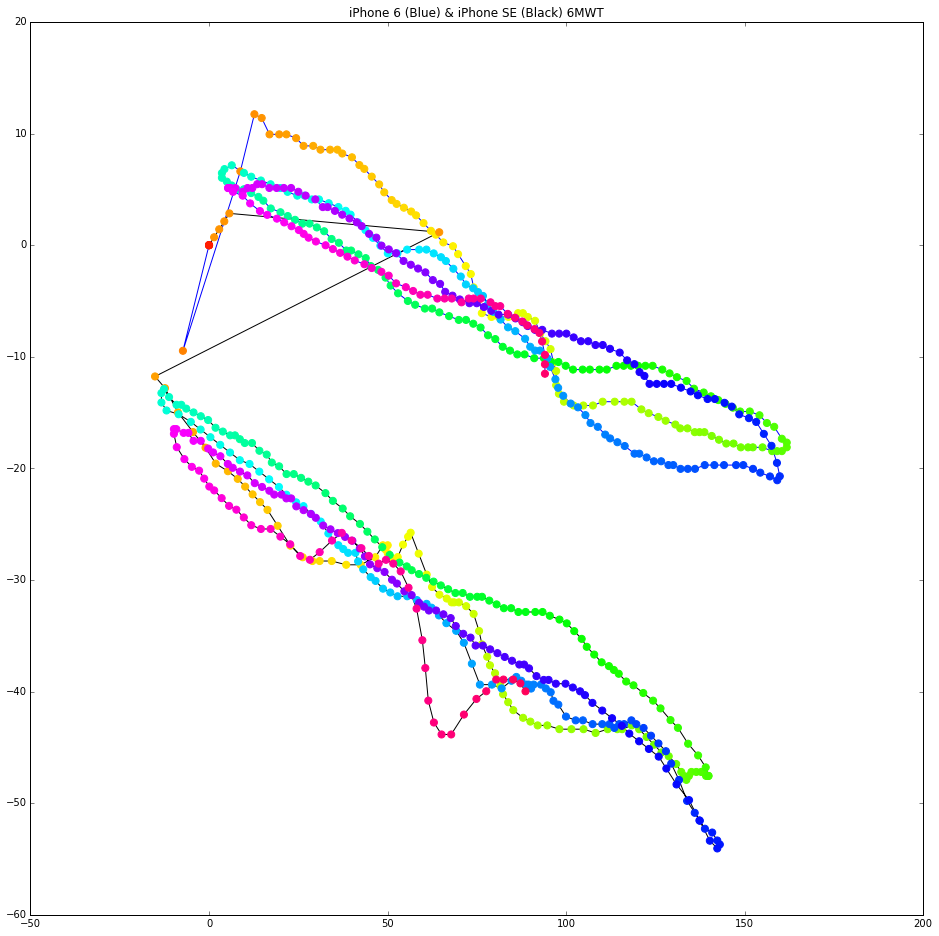

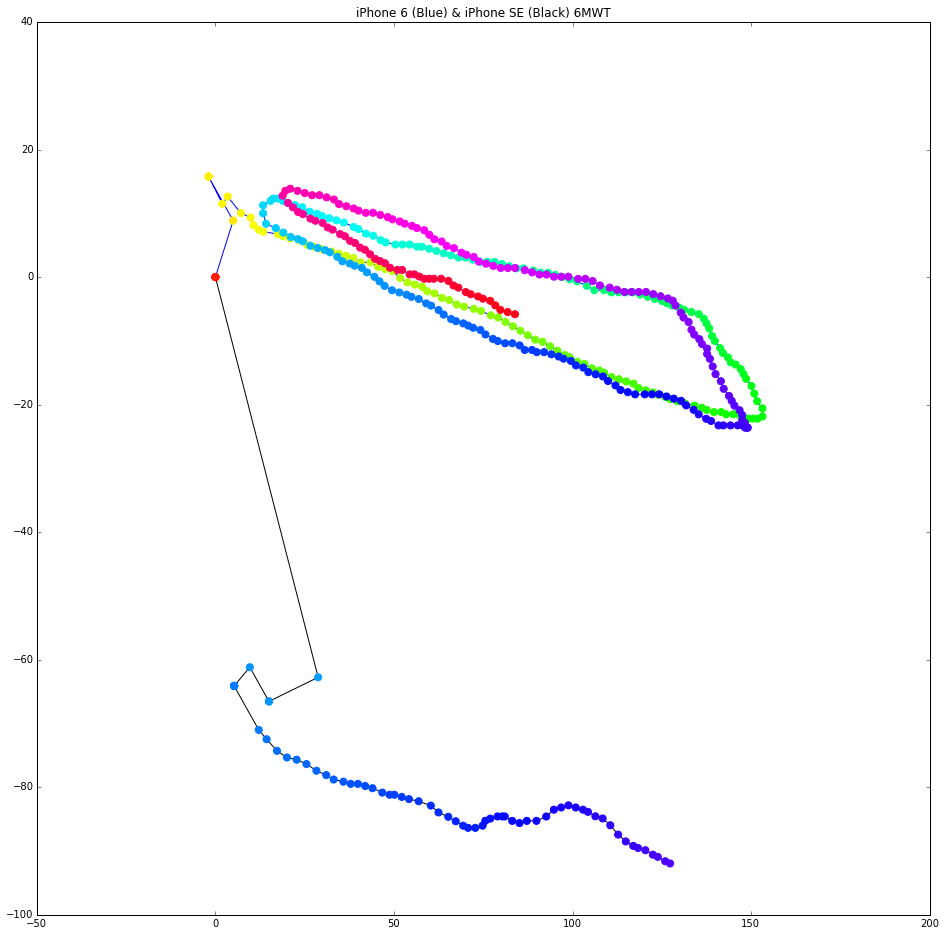

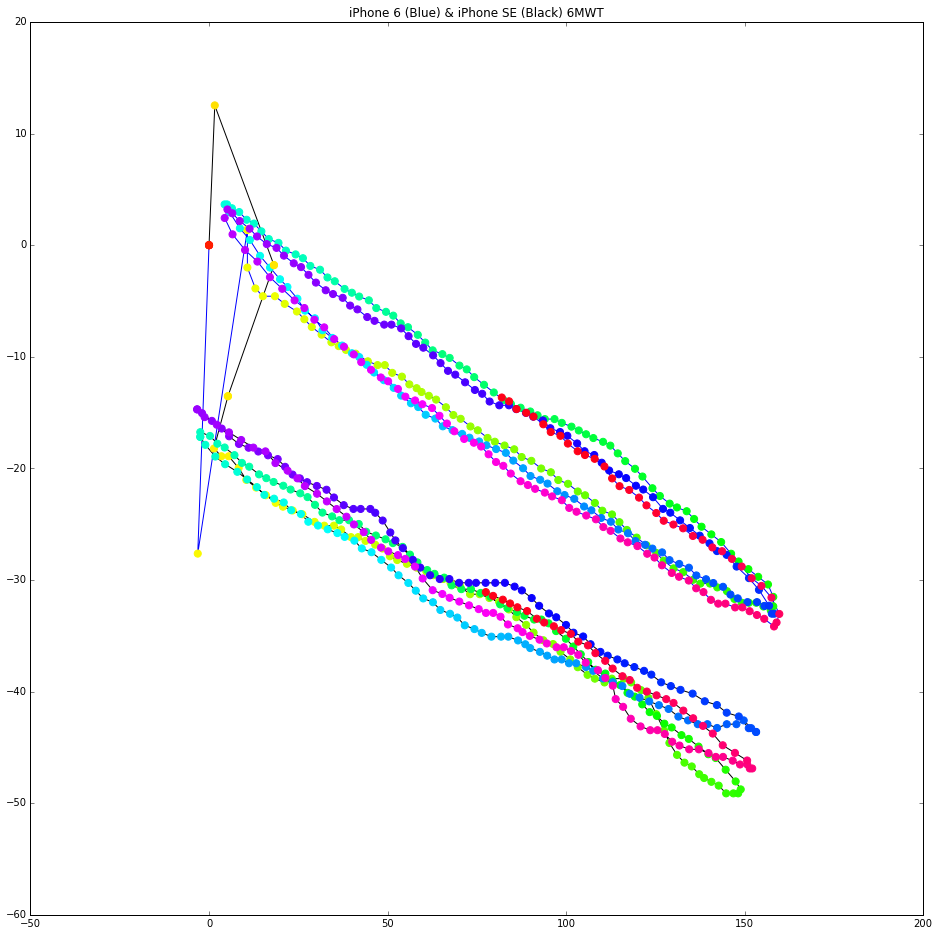

In [146]:
# Plot reconstructed path from both devices
done=set()
for row in disp_df.iterrows():
    t_diff = disp_df["createdOn"]-disp_df["createdOn"][row[0]]
    run_df = disp_df[t_diff.map(toSeconds)<360]
    if run_df.size > 11:
        phoneTofile = {}
        phoneTofile[run_df.irow(0)['phoneInfo']] = str(run_df.irow(0)['UnknownFile_1.json.items'])
        phoneTofile[run_df.irow(1)['phoneInfo']] = str(run_df.irow(1)['UnknownFile_1.json.items'])
        if not phoneTofile["iPhone 6"] in done:
            DistPlots(join(base_path, "UnknownFile_1.json.items", phoneTofile["iPhone 6"]), \
                      join(base_path, "UnknownFile_1.json.items", phoneTofile["iPhone8,4"]), 
                      560)
            done.add(phoneTofile["iPhone 6"])

### Data for ticket MHC-473

recordID, phone (# data points, time range)

In [145]:
def TimeRange(in_fn):
    df = pd.read_json(in_fn)

    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S-0700')
    df["timestamp_time"] = df["timestamp"].apply(dateparse)
    df["timestamp_offset"] = df["timestamp_time"] - min(df["timestamp_time"])
    
    return len(df), (df["timestamp_offset"].max()-df["timestamp_offset"].min()).total_seconds()
    
    
for row in disp_df.iterrows():
    print row[1]["recordId"], row[1]['phoneInfo'], TimeRange(join(base_path, "UnknownFile_1.json.items", str(row[1]['UnknownFile_1.json.items'])))

 75957a49-cac5-4cfc-b3d9-6fc53b70c355 iPhone8,4 (18, 154.0)
db81f279-89fa-4e2d-a3ec-e6fe03313b3b iPhone8,4 (71, 97.0)
7b98820d-3142-428b-8e6c-0e7b85181d94 iPhone8,4 (87, 125.0)
2bf3e3dd-eda3-48e3-88e6-9f269f354f9d iPhone 6 (364, 642.0)
259c9eaa-1081-4923-90ce-28093a45b6af iPhone8,4 (74, 106.0)
adbf96d9-4bcc-4364-bbc4-4f5e6a747b68 iPhone 6 (365, 626.0)
17dbc5ea-c97d-456a-a58f-9df808344811 iPhone8,4 (76, 268.0)
9066b05b-7608-48c4-b0a4-20ddd99bd5a2 iPhone 6 (365, 485.0)
59d3dda8-4975-452f-b8c9-d75113ccac16 iPhone8,4 (364, 471.0)
0fd961f3-2853-41f5-89b1-99293bcd2b0f iPhone8,4 (88, 226.0)
1b557091-0a07-4484-8db3-1744b3bb59be iPhone8,4 (364, 497.0)
ab6c65d6-9a43-4935-8ab4-005507cd223c iPhone 6 (365, 418.0)
a8f2c146-f86b-4ca4-9003-f0266da99c12 iPhone8,4 (366, 456.0)
afa743cb-b3a6-4245-84b3-939d13fc6dc3 iPhone8,4 (362, 429.0)
af58e426-9bb3-42cd-8f2a-e7b19b1ac526 iPhone 6 (364, 428.0)
b3b523d9-ea20-4f3c-bcd7-0194a220db92 iPhone 6 (364, 452.0)
50415c59-33d8-42d4-9e84-84aca4484de5 iPhone8,4 (71, 

# Plotting time vs distance along track

This was computed using distance from a fixed point (min(x), min(y)). I'm not 100% that was the right way to compute distance along truck

Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot


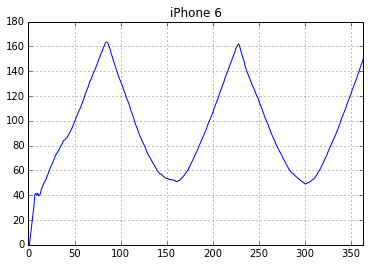

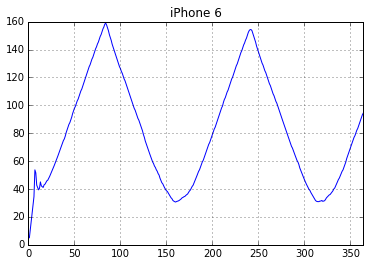

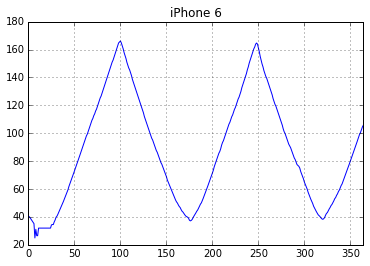

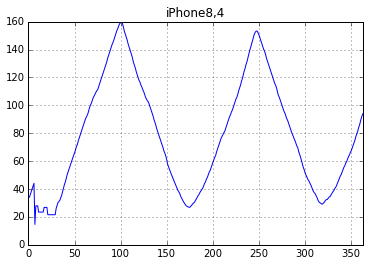

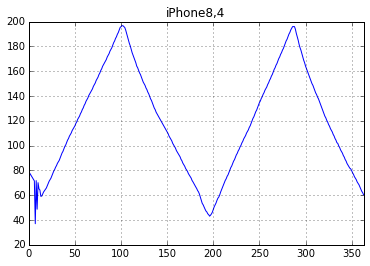

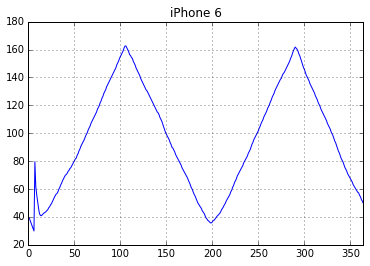

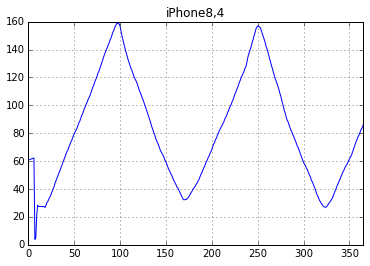

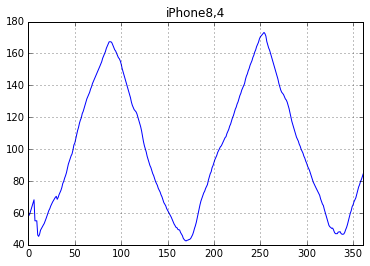

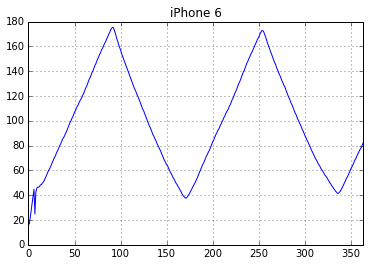

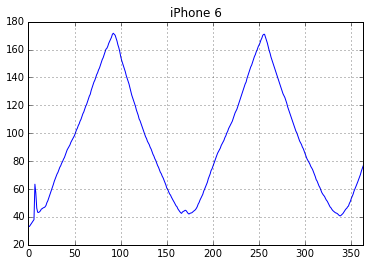

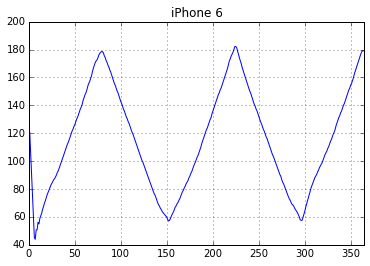

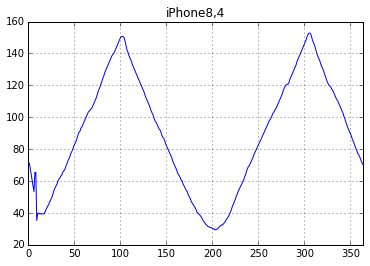

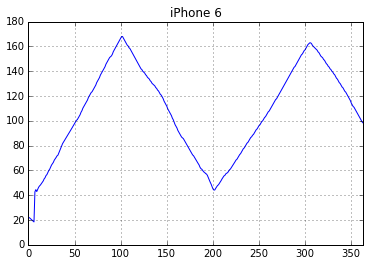

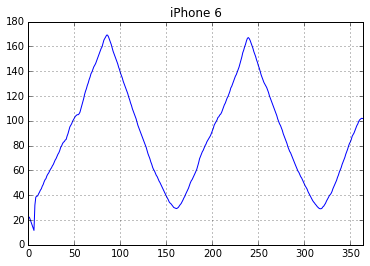

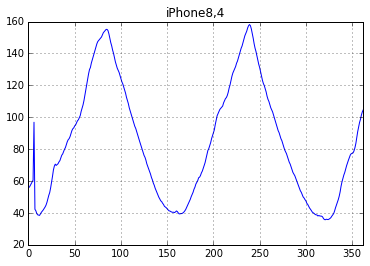

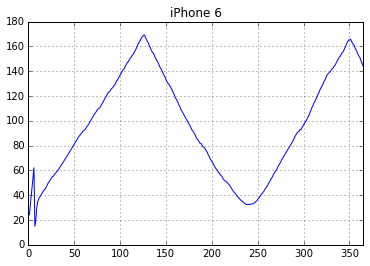

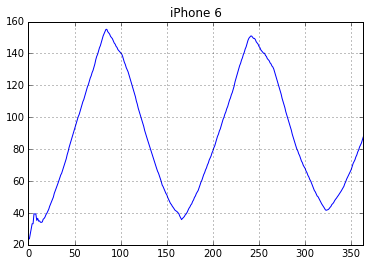

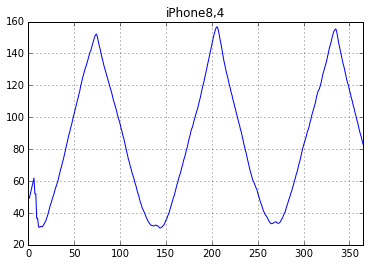

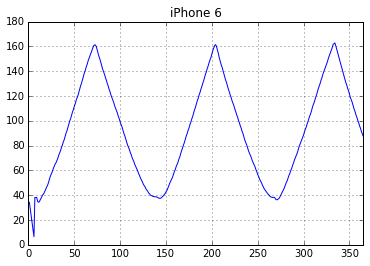

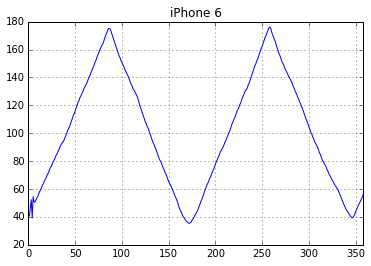

In [171]:
#Plot time vs displacement
for row in disp_df.iterrows():
    df = DispFromZeroPlot(join(base_path, "UnknownFile_1.json.items", str(row[1]['UnknownFile_1.json.items'])),\
                    title = row[1]['phoneInfo'])


Short df, no plot
Short df, no plot
Short df, no plot
Short df, no plot


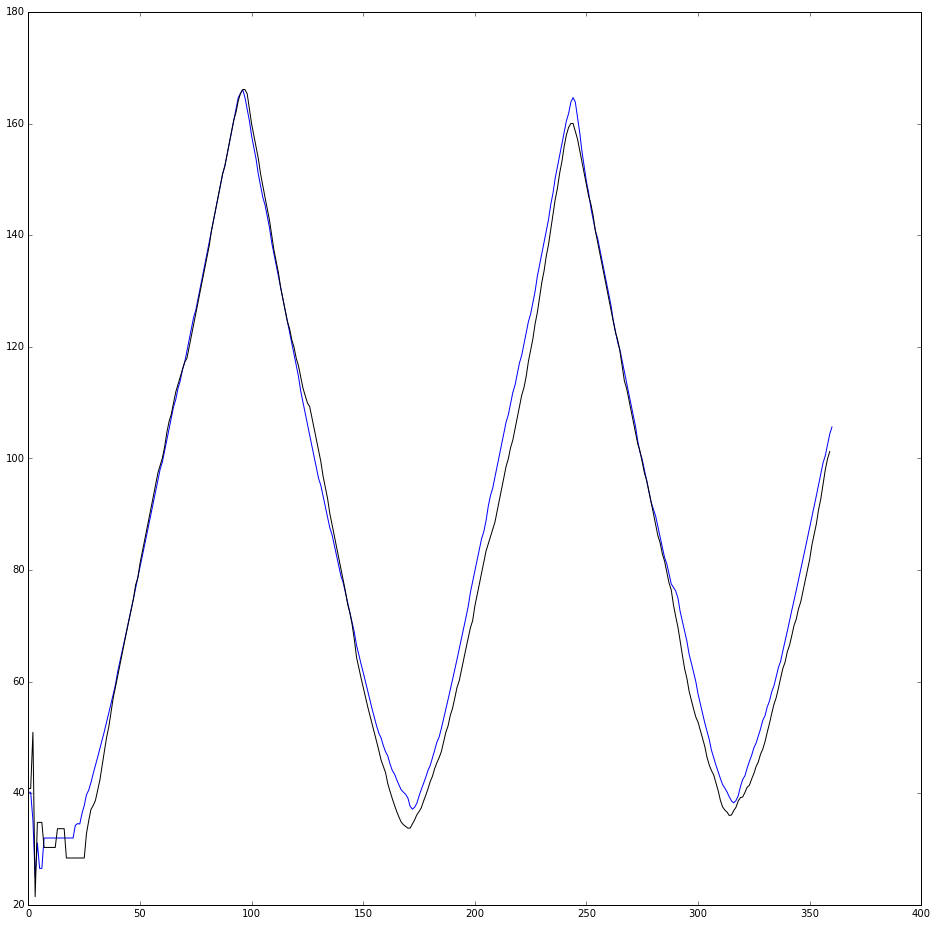

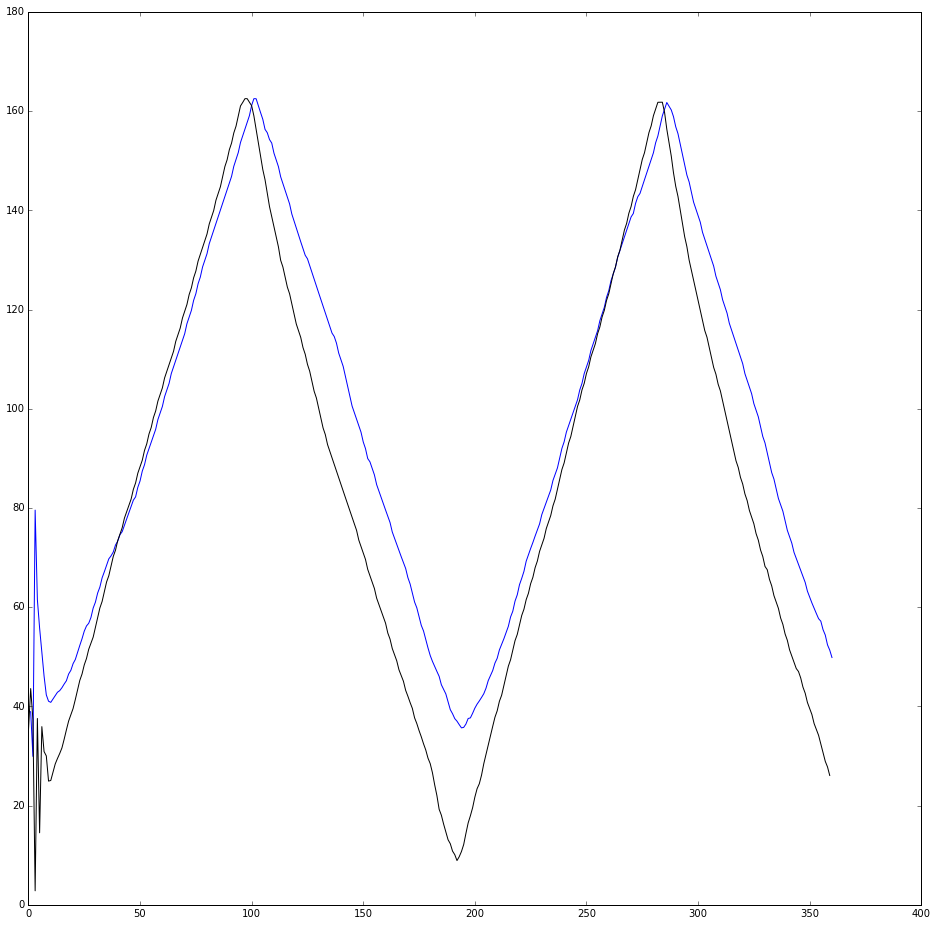

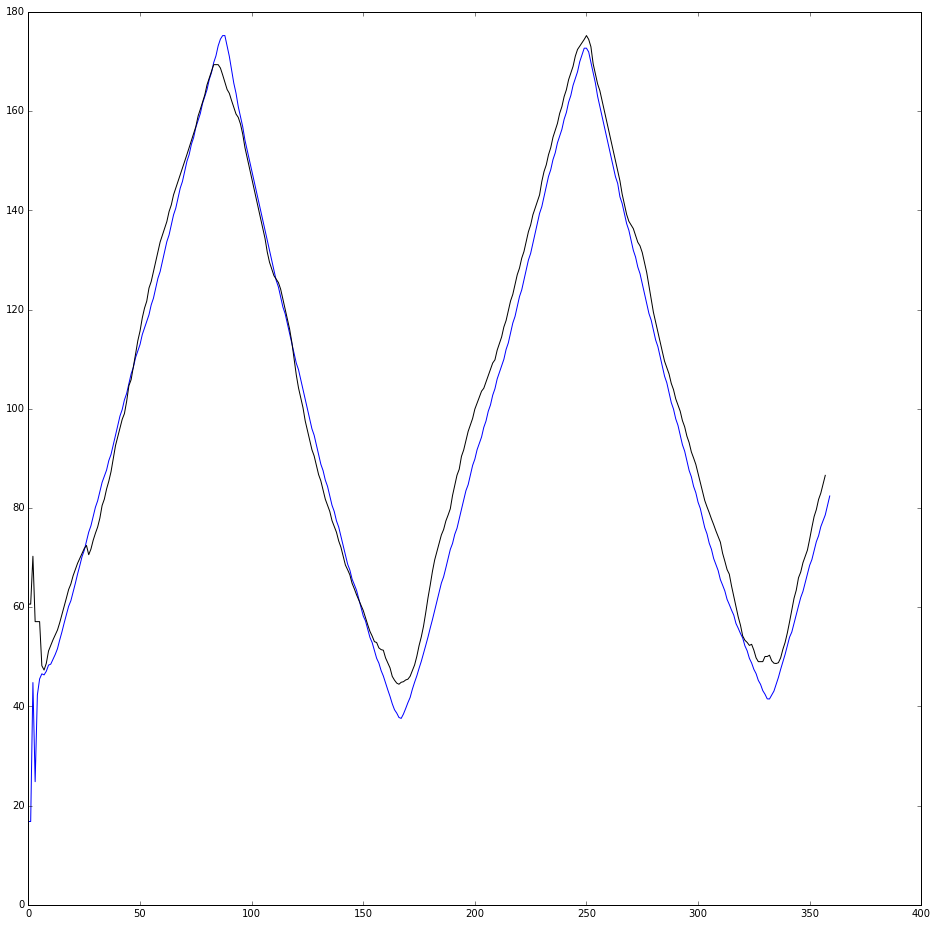

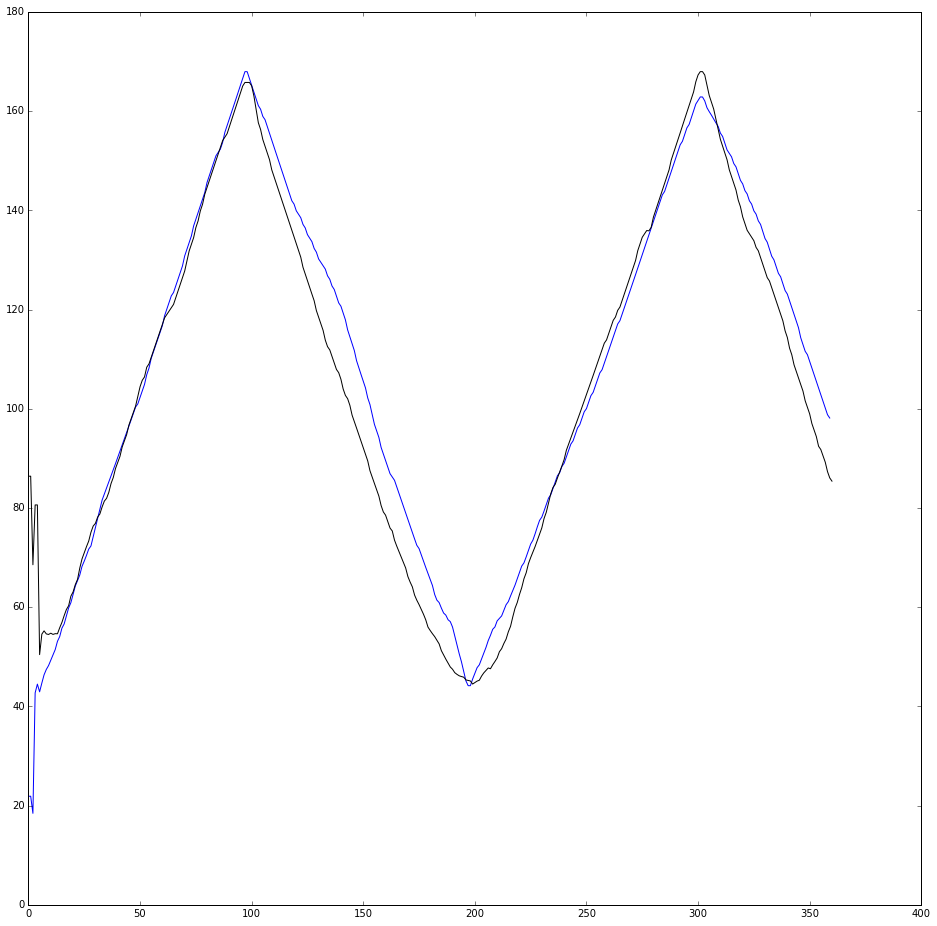

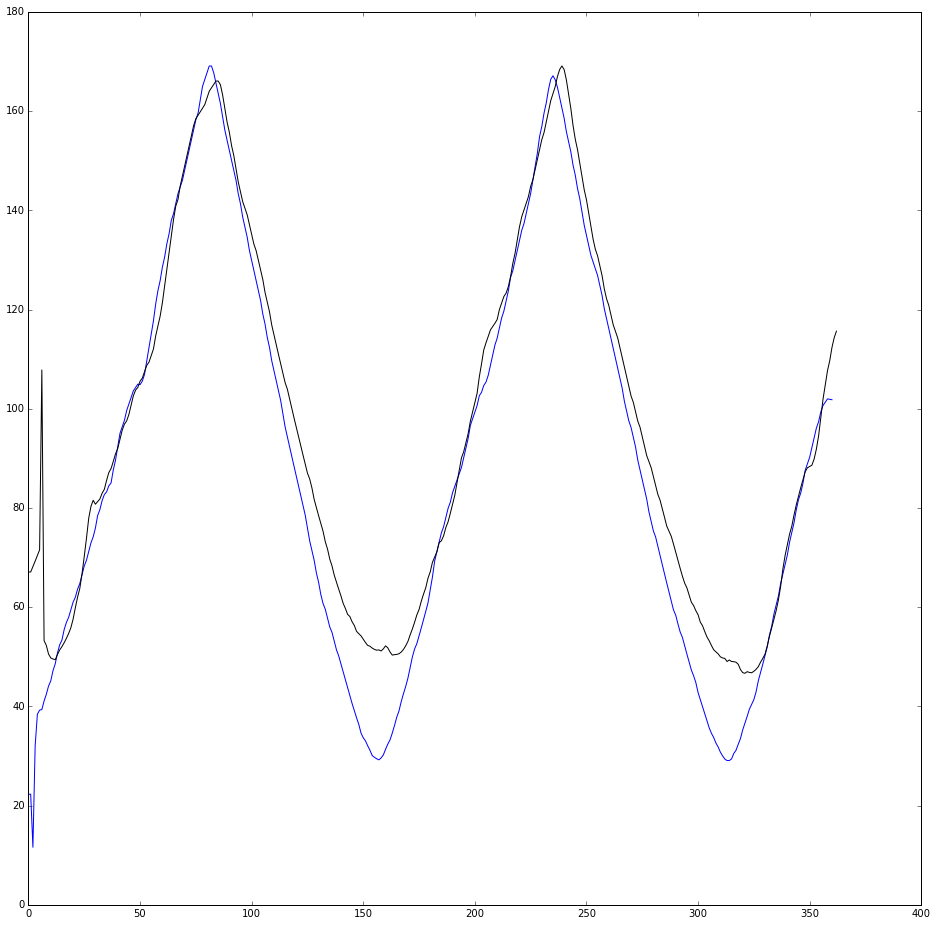

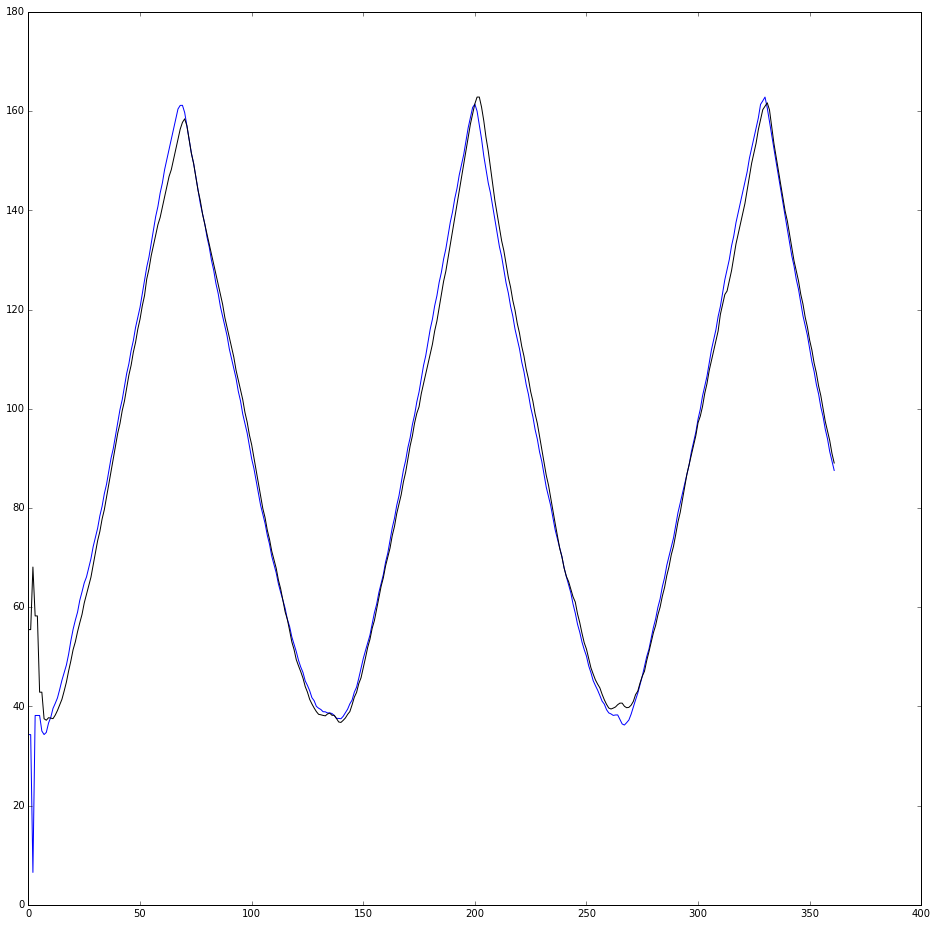

In [180]:
# Plot time vs displacement for iPhone and iPod
done=set()
for row in disp_df.iterrows():
    t_diff = disp_df["createdOn"]-disp_df["createdOn"][row[0]]
    run_df = disp_df[t_diff.map(toSeconds)<360]
    if run_df.size > 11:
        phoneTofile = {}
        phoneTofile[run_df.irow(0)['phoneInfo']] = str(run_df.irow(0)['UnknownFile_1.json.items'])
        phoneTofile[run_df.irow(1)['phoneInfo']] = str(run_df.irow(1)['UnknownFile_1.json.items'])
        if not phoneTofile["iPhone 6"] in done:
            DispFromZeroPlots(join(base_path, "UnknownFile_1.json.items", phoneTofile["iPhone 6"]), \
                      join(base_path, "UnknownFile_1.json.items", phoneTofile["iPhone8,4"]), 
                      560)
            done.add(phoneTofile["iPhone 6"])

# Identify Peaks

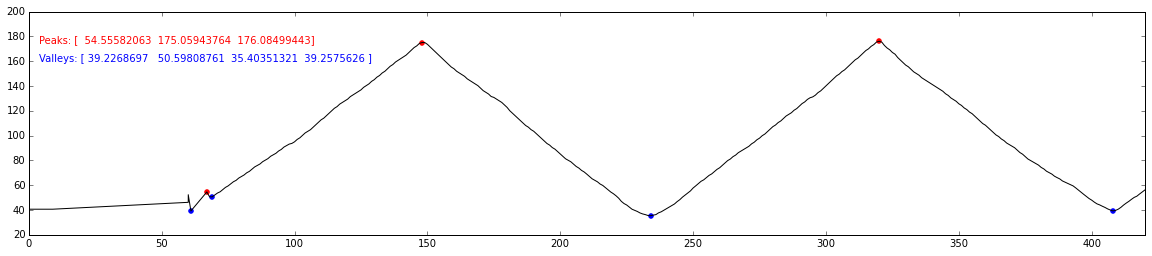

In [307]:
peaks = peakutils.indexes(df.disp_from_min, thres=0.0, min_dist=2)
valleys = peakutils.indexes(-df.disp_from_min, thres=0.0, min_dist=2)
indices = peaks.tolist()  + valleys.tolist()
indices.sort()

# peakutils.interpolate(df.timestamp_offset.map(toSeconds).values, df.disp_from_min.values, ind=indices)

x = df.timestamp_offset.map(toSeconds).values
y = df.disp_from_min.values

fig, ax = plt.subplots(figsize=(20,4))
ax.set_xlim(x.min(),x.max())
ax.plot(x,y, color="k")
ax.scatter(x[peaks],y[peaks], color="red")
ax.scatter(x[valleys],y[valleys], color="blue")
ax.text(4, 175, "Peaks: "+str(y[peaks]), color="red")
ax.text(4, 160, "Valleys: "+str(y[valleys]), color="blue")

In [270]:
y[peaks], y[valleys]

(array([  54.55582063,  175.05943764,  176.08499443]),
 array([ 39.2268697 ,  50.59808761,  35.40351321,  39.2575626 ]))

Short df, no plot
Short df, no plot
Short df, no plot
[  26.26572019  156.36998627   38.26896526   37.93132199  154.64218562
   34.92667388] [ 24.04384529  38.14911994  37.38493573  35.80449412  34.51884803
  34.8982811 ]
Short df, no plot
[  42.97611676  154.61563558  150.01419921   31.49979746] [ 37.95962331  38.43235889  29.84315534  29.63459039  30.55736578]
Short df, no plot
[  20.38464558   29.30956363  151.99460472   35.2246358   150.5451622
   33.9297009 ] [ 20.27707059  27.41638455  35.05678644  31.20321609  33.91405134
  33.27710845]
[  25.13423246  154.41075003  148.33432479   30.37334986] [ 22.58788928  19.00801757  25.02290531  27.51359126  30.24500866]
Short df, no plot
[  70.09895467  196.70373642  195.99190866] [ 37.00172833  59.1162499   43.09727631]
[  36.14020345  148.33551812   28.92051953   30.61996908  147.56694848] [ 35.09339248  35.5059388   28.8901314   28.57237188  30.07852247]
[  26.40373606   26.43598062  155.3525522   153.02341797] [ 25.83102915  25.1851208

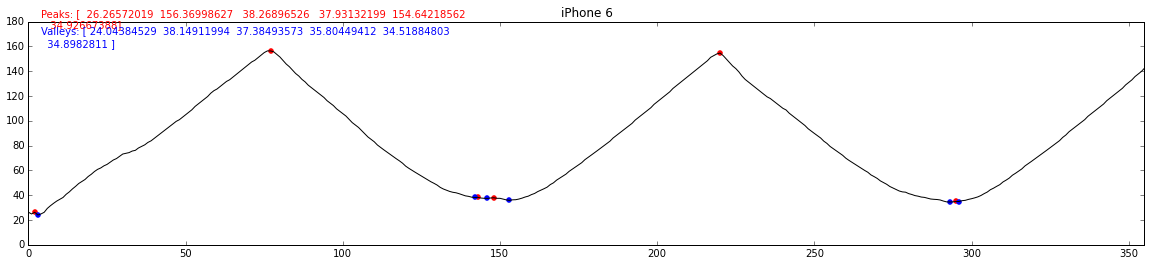

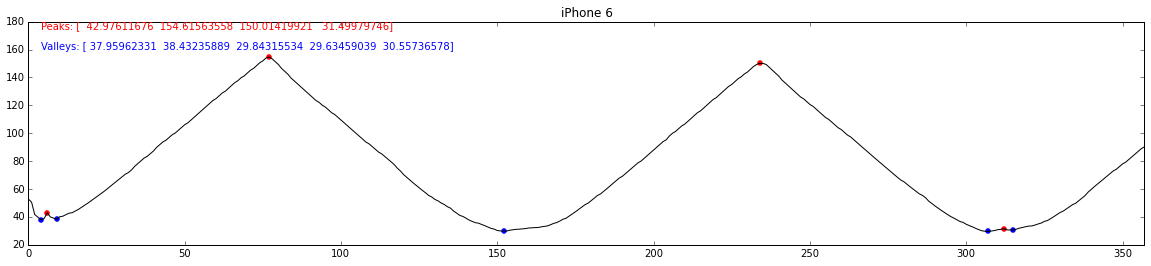

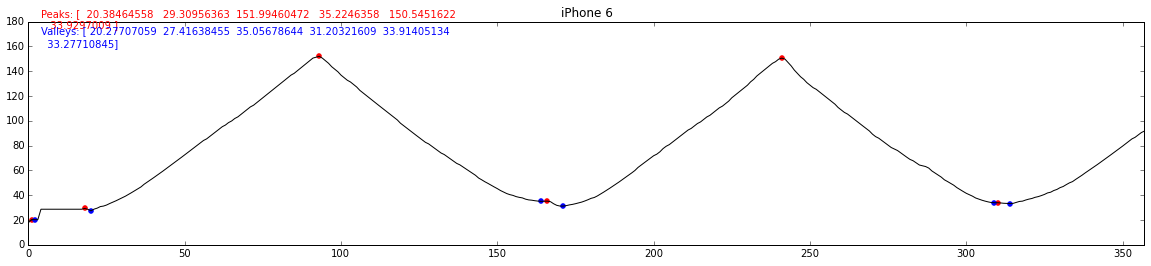

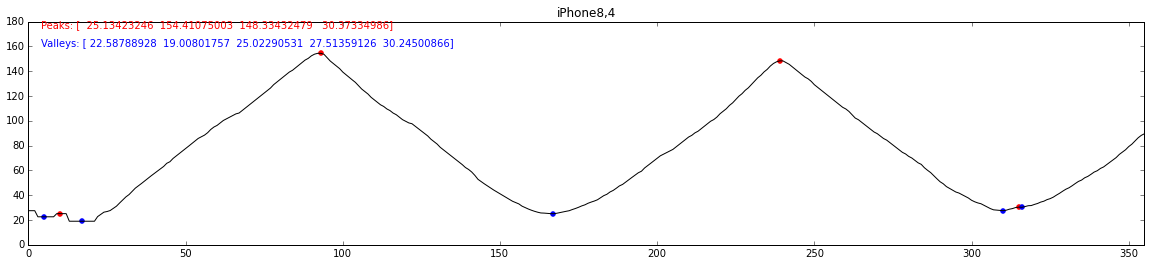

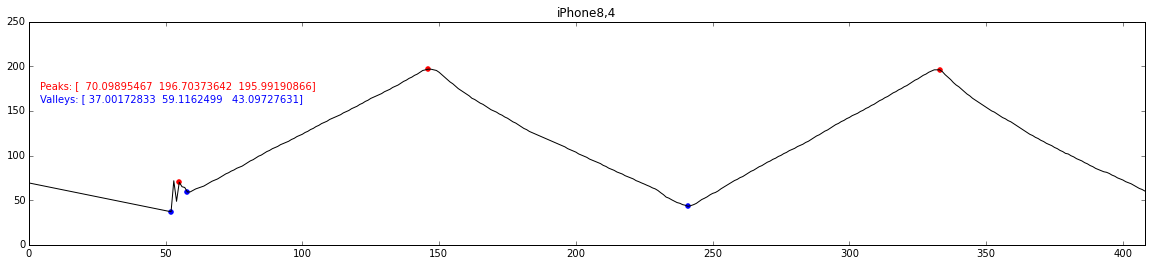

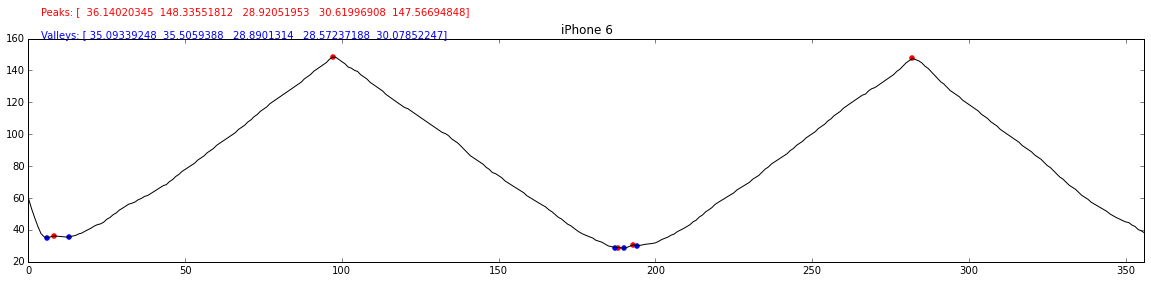

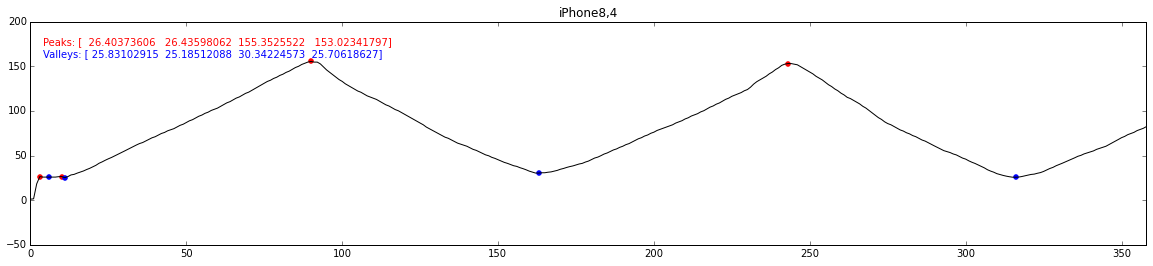

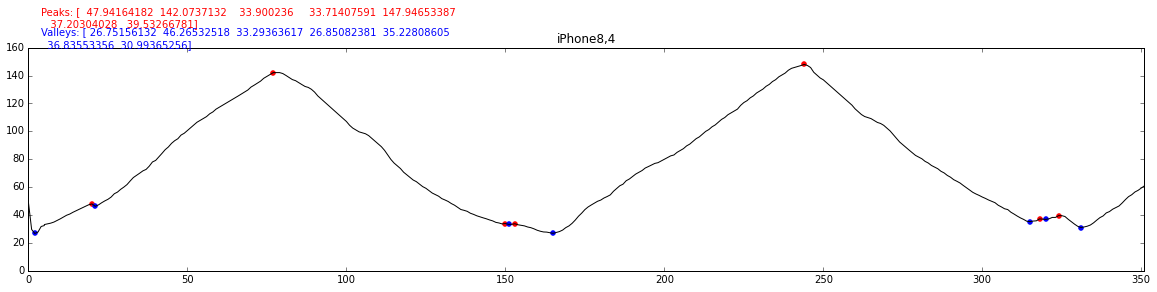

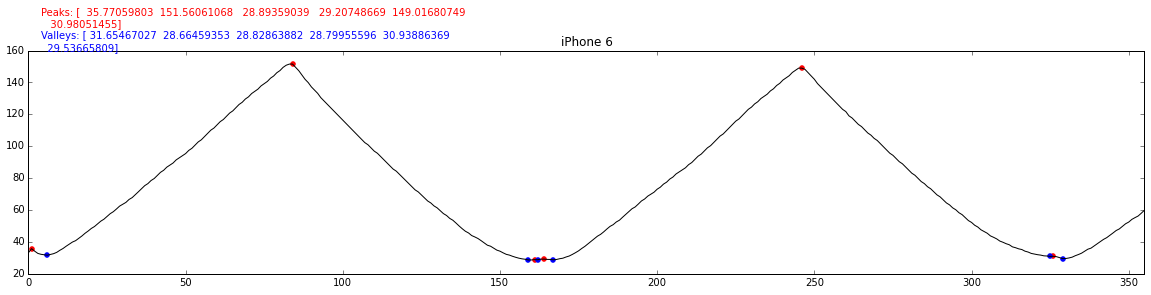

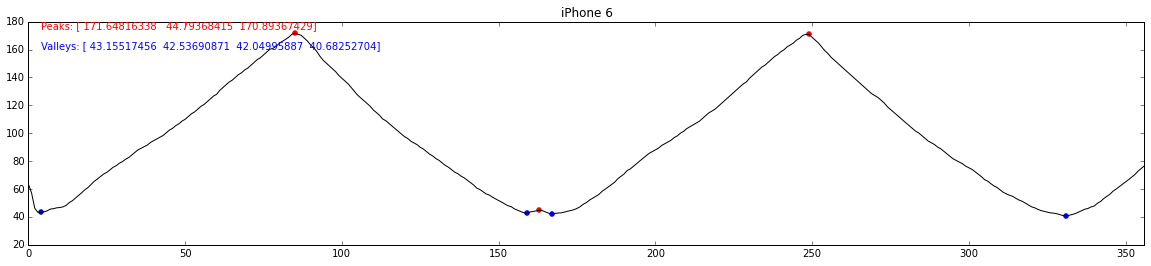

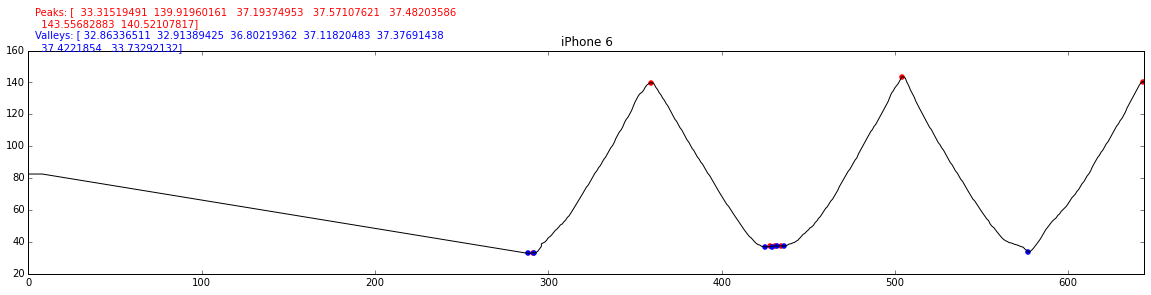

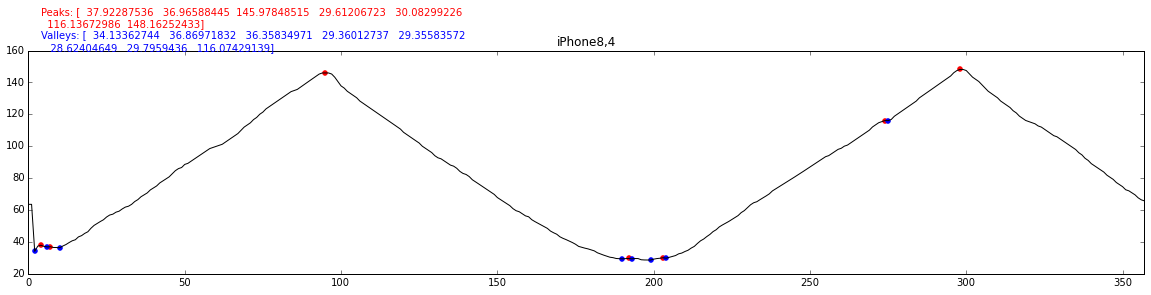

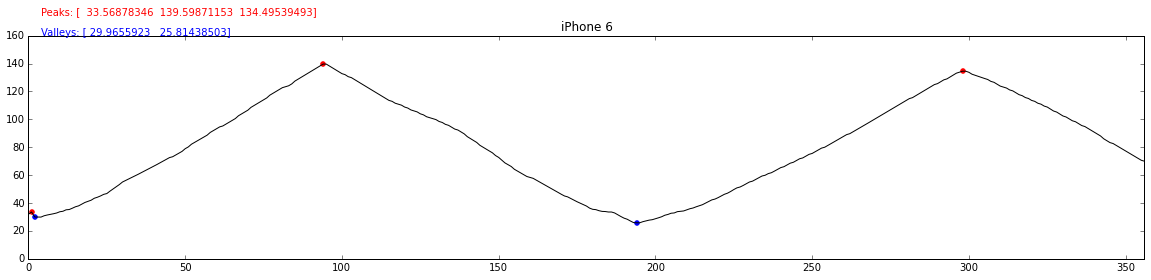

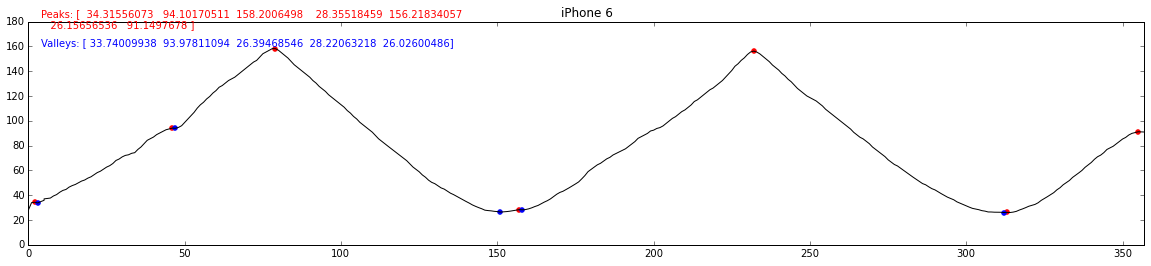

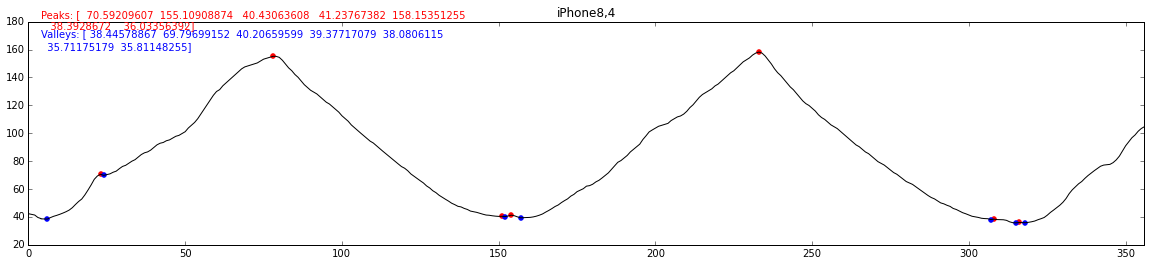

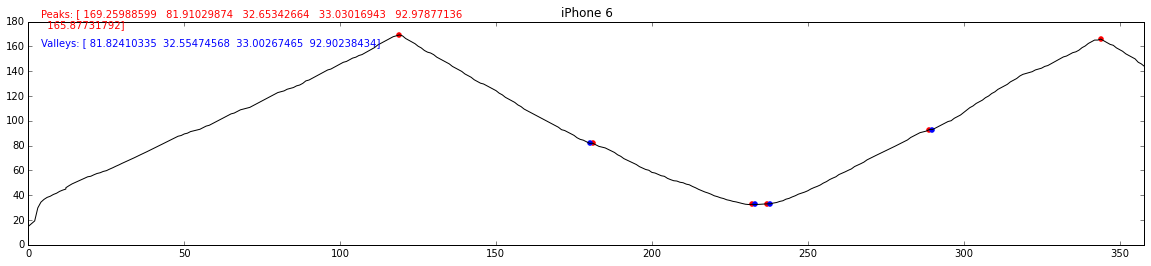

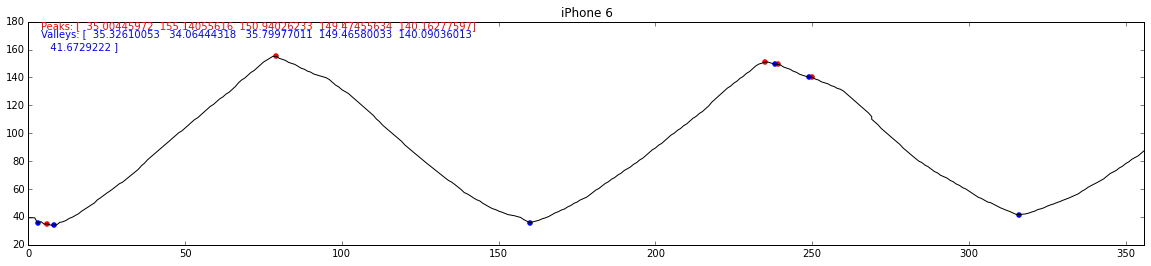

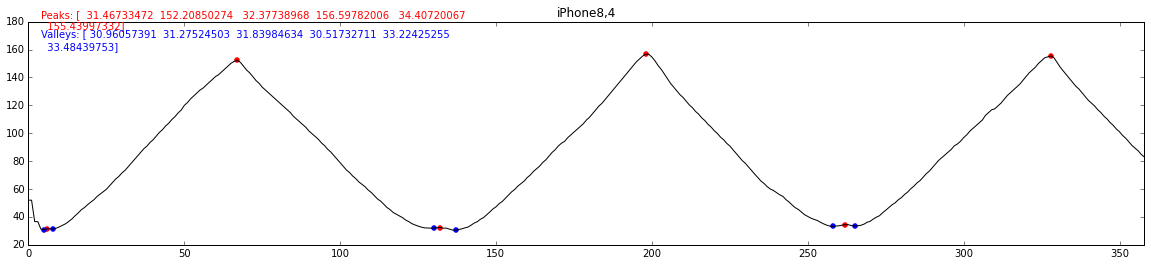

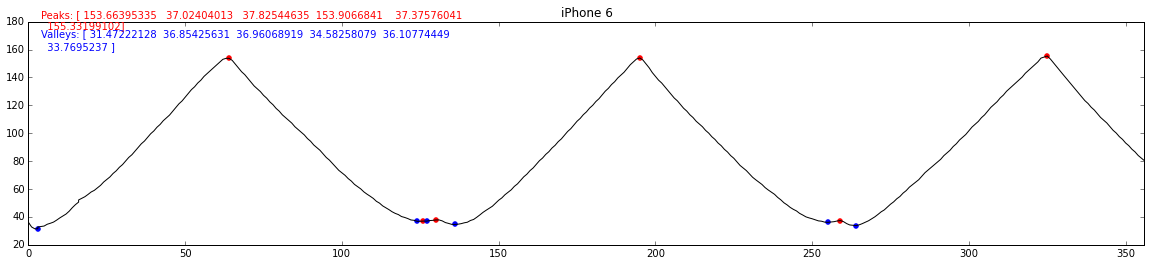

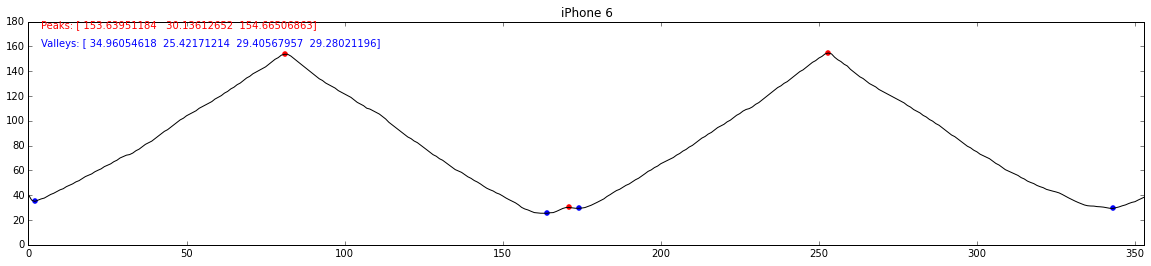

In [317]:
#Plot Peaks for all
for row in disp_df.iterrows():
    res = PeakPlot(join(base_path, "UnknownFile_1.json.items", str(row[1]['UnknownFile_1.json.items'])),\
                    title = row[1]['phoneInfo'], filt=50)
    if res is not None:
        x, y, y_p, y_v = res


# Other analysis ideas
* time vs horizontal error
* Plot altitute walking back an forth